## Air Quality Index Prediction

<table>
    <thead>
        <tr>
            <th>Daily AQI Color</th>
            <th>Levels of Concern</th>
            <th>Values of Index</th>
            <th>Description of Air Quality</th>
        </tr>
    </thead>
    <tbody>
        <tr style="background-color: green;">
            <td>Green</td>
            <td>Good</td>
            <td>0 to 50</td>
            <td>Air quality is satisfactory, and air pollution poses little or no risk.</td>
        </tr>
        <tr style="background-color: yellow;">
            <td>Yellow</td>
            <td>Moderate</td>
            <td>51 to 100</td>
            <td>Air quality is acceptable. However, there may be a risk for some people, particularly those who are unusually sensitive to air pollution.</td>
        </tr>
        <tr style="background-color: orange;">
            <td>Orange</td>
            <td>Unhealthy for Sensitive Groups</td>
            <td>101 to 150</td>
            <td>Members of sensitive groups may experience health effects. The general public is less likely to be affected.</td>
        </tr>
        <tr style="background-color: red;">
            <td>Red</td>
            <td>Unhealthy</td>
            <td>151 to 200</td>
            <td>Some members of the general public may experience health effects; members of sensitive groups may experience more serious health effects.</td>
        </tr>
        <tr style="background-color: purple;">
            <td>Purple</td>
            <td>Very Unhealthy</td>
            <td>201 to 300</td>
            <td>Health alert: The risk of health effects is increased for everyone.</td>
        </tr>
        <tr style="background-color: maroon;">
            <td>Maroon</td>
            <td>Hazardous</td>
            <td>301 and higher</td>
            <td>Health warning of emergency conditions: everyone is more likely to be affected.</td>
        </tr>
    </tbody>
</table>


# Implementation

In [22]:
# PySpark imports
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import (
    year, col, dense_rank, mean, to_date, avg, first, desc, row_number, concat_ws, when, asc
)
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Other imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import time

#### Beginning the session

In [23]:

# Stop any existing Spark session
spark = SparkSession.builder.getOrCreate()
spark.stop()

# Create a new SparkSession with desired configuration
spark = SparkSession.builder \
    .appName('pollution') \
    .getOrCreate()


## Exploratory Data Analysis


In [24]:
###Database paths
folder_path = "pollutants/NO2/"
NO2 = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

folder_path = "pollutants/CO/"
CO = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

folder_path = "pollutants/O3/"
O3 = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

folder_path = "pollutants/SO2/"
SO2 = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

folder_path = "pollutants/2.5/"
PM25 = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

#### Selecting columns and renaming them

In [25]:
#NO2.columns
#Select

newNO2 = NO2.select('Date Local', 'State Name', 'City Name', 'Arithmetic Mean', 'Units of Measure', 'AQI') \
                    .withColumnRenamed('Arithmetic Mean', 'NO2 mean') \
                    .withColumnRenamed('AQI', 'NO2 AQI') \
                    .withColumnRenamed('Units of Measure', 'Units of Measure NO2')


newCO = CO.select('Date Local', 'State Name', 'City Name', 'Arithmetic Mean', 'Units of Measure') \
                .withColumnRenamed('Arithmetic Mean', 'CO Mean')\
                .withColumnRenamed('Units of Measure', 'Units of Measure CO')


newO3 = O3.select('Date Local', 'State Name', 'City Name', 'Arithmetic Mean', 'Units of Measure', 'AQI') \
                .withColumnRenamed('Arithmetic Mean', 'O3 Mean') \
                    .withColumnRenamed('AQI', 'O3 AQI')\
                    .withColumnRenamed('Units of Measure', 'Units of Measure O3')

newSO2 = SO2.select('Date Local', 'State Name', 'City Name', 'Arithmetic Mean', 'Units of Measure', 'AQI') \
                .withColumnRenamed('Arithmetic Mean', 'SO2 Mean') \
                    .withColumnRenamed('AQI', 'SO2 AQI')\
                    .withColumnRenamed('Units of Measure', 'Units of Measure SO2')

newPM25 = PM25.select('Date Local', 'State Name', 'City Name', 'Arithmetic Mean', 'Units of Measure', 'AQI') \
                .withColumnRenamed('Arithmetic Mean', '25pm Mean') \
                    .withColumnRenamed('AQI', '25pm AQI')\
                    .withColumnRenamed('Units of Measure', 'Units of Measure 25pm')

In [29]:
#Columns to join
join_columns = ["Date Local", "State Name", "City Name"]



#### First merge: Pollution Gases

In [30]:
#This takes less time than joining and doing an avg on all ?
join_columns = ["Date Local", "State Name", "City Name"]
merged_df = newCO.join(newO3, on=join_columns, how='inner')
merged_df = merged_df.groupby('Date Local', 'State Name', 'City Name').avg()
merged_df = merged_df.orderBy('Date Local', 'State Name', 'City Name')
#merged_df.show()

#merged_df.show()
merged_df = merged_df.join(newNO2, on=join_columns, how='inner')
merged_df = merged_df.groupby('Date Local', 'State Name', 'City Name').avg()
merged_df = merged_df.orderBy('Date Local', 'State Name', 'City Name')
#merged_df.show()

merged_df = merged_df.join(newPM25, on=join_columns, how='inner')
merged_df = merged_df.groupby('Date Local', 'State Name', 'City Name').avg()
merged_df = merged_df.orderBy('Date Local', 'State Name', 'City Name')
#merged_df.show()

merged_df = merged_df.join(newSO2, on=join_columns, how='inner')
merged_df = merged_df.groupby('Date Local', 'State Name', 'City Name').avg()
merged_df = merged_df.orderBy('Date Local', 'State Name', 'City Name')
merged_df.show()


+----------+-----------+-----------------+---------------------------+---------------------------+--------------------------+-----------------------+----------------------+-------------------+------------------+-------------------+-----------------+
|Date Local| State Name|        City Name|avg(avg(avg(avg(CO Mean))))|avg(avg(avg(avg(O3 Mean))))|avg(avg(avg(avg(O3 AQI))))|avg(avg(avg(NO2 mean)))|avg(avg(avg(NO2 AQI)))|avg(avg(25pm Mean))|avg(avg(25pm AQI))|      avg(SO2 Mean)|     avg(SO2 AQI)|
+----------+-----------+-----------------+---------------------------+---------------------------+--------------------------+-----------------------+----------------------+-------------------+------------------+-------------------+-----------------+
|2014-01-01|    Alabama|       Birmingham|        0.31144700000000003|                   0.017059|                      19.0|     17.327989000000002|                  35.0|         14.3270835|              56.0|          0.3032465|              3.0|


In [31]:
#Clean column names
# Initial columns in merged_df
cols = merged_df.columns

# New DataFrame with cleaned column names
for col in cols:
    clean_col_name = col.replace("avg(", "").replace(")", "").strip()
    merged_df = merged_df.withColumnRenamed(col, clean_col_name)

# Now merged_df has cleaned column names


In [32]:
merged_df.printSchema()

root
 |-- Date Local: string (nullable = true)
 |-- State Name: string (nullable = true)
 |-- City Name: string (nullable = true)
 |-- CO Mean: double (nullable = true)
 |-- O3 Mean: double (nullable = true)
 |-- O3 AQI: double (nullable = true)
 |-- NO2 mean: double (nullable = true)
 |-- NO2 AQI: double (nullable = true)
 |-- 25pm Mean: double (nullable = true)
 |-- 25pm AQI: double (nullable = true)
 |-- SO2 Mean: double (nullable = true)
 |-- SO2 AQI: double (nullable = true)



In [33]:
merged_df.select('City Name', 'Date Local', 'CO Mean', 'SO2 mean', 'SO2 AQI').show(n=20)

+-----------------+----------+-------------------+-------------------+-----------------+
|        City Name|Date Local|            CO Mean|           SO2 mean|          SO2 AQI|
+-----------------+----------+-------------------+-------------------+-----------------+
|       Birmingham|2014-01-01|0.31144700000000003|          0.3032465|              3.0|
|          Phoenix|2014-01-01| 1.1821688333333322| 1.6847221666666667|6.333333333333333|
|           Tucson|2014-01-01| 0.4353946999999997|0.31666649999999996|              0.0|
|North Little Rock|2014-01-01|0.36463825000000005|         1.62916675|              3.0|
|     Arden-Arcade|2014-01-01|           0.651294| 0.5791664999999999|              1.0|
|          Burbank|2014-01-01|          1.6190825| 1.5003104999999999|              3.0|
|         Calexico|2014-01-01| 0.7031229999999999| 1.1850930000000002|              6.0|
|          Concord|2014-01-01|           0.539976|0.45551949999999997|              3.0|
|         El Cajon|20

In [34]:
#merged_df.drop()

In [35]:
#merged_df.show(n=2)

#### Filtering out the top 5

In [36]:
windowSpec = Window.partitionBy("Date Local").orderBy(desc("O3 Mean"))

windowSpecN = Window.partitionBy("Date Local").orderBy(desc("NO2 Mean"))

windowSpecC = Window.partitionBy("Date Local").orderBy(desc("CO Mean"))

windowSpecP = Window.partitionBy("Date Local").orderBy(desc("25pm Mean"))

windowSpecS = Window.partitionBy("Date Local").orderBy(desc("SO2 Mean"))


In [37]:
#merged_df.show()

In [38]:
#top 5 daily
top_O3 = newO3.withColumn("rank", row_number().over(windowSpec)) \
                 .filter("rank <= 5") \
                 .select("Date Local", "City Name", "State Name", "O3 Mean", "Units of Measure O3", "O3 AQI")

top_NO2 = newNO2.withColumn("rank", row_number().over(windowSpecN)) \
                 .filter("rank <= 5") \
                 .select("Date Local", "City Name", "State Name", "NO2 Mean", "Units of Measure NO2", "NO2 AQI")

top_CO = newCO.withColumn("rank", row_number().over(windowSpecC)) \
                 .filter("rank <= 5") \
                 .select("Date Local", "City Name", "State Name", "CO Mean", "Units of Measure CO")

top_PM25 = newPM25.withColumn("rank", row_number().over(windowSpecP)) \
                 .filter("rank <= 5") \
                 .select("Date Local", "City Name", "State Name", "25pm Mean", "Units of Measure 25pm", "25pm AQI")

top_SO2 = newSO2.withColumn("rank", row_number().over(windowSpecS)) \
                 .filter("rank <= 5") \
                 .select("Date Local", "City Name", "State Name", "SO2 Mean", "Units of Measure SO2", "SO2 AQI")

In [40]:
top_O3.count()

16134

#### Top 5 offenders per day, only using O3 as example usage

In [41]:
top_O3.orderBy(asc('Date Local')).show() 

+----------+-------------+-------------+--------+-------------------+------+
|Date Local|    City Name|   State Name| O3 Mean|Units of Measure O3|O3 AQI|
+----------+-------------+-------------+--------+-------------------+------+
|2014-01-01|Not in a city|   California|0.053412|  Parts per million|    51|
|2014-01-01|Not in a city|         Utah|    0.06|  Parts per million|    97|
|2014-01-01|Not in a city|         Utah|0.052412|  Parts per million|   105|
|2014-01-01|Not in a city|         Utah|0.077882|  Parts per million|   164|
|2014-01-01|       Alpine|   California|0.051118|  Parts per million|    49|
|2014-01-02|Not in a city|   California|0.057235|  Parts per million|    67|
|2014-01-02|Not in a city|         Utah|0.055471|  Parts per million|    74|
|2014-01-02|Not in a city|         Utah|0.075471|  Parts per million|   156|
|2014-01-02|Not in a city|         Utah|0.056471|  Parts per million|   119|
|2014-01-02|     Maricopa|   California|0.053353|  Parts per million|    71|

#### Ranking the yearly offenders

In [42]:


def yearly_top_pollutants(dataframe, pollutant_name, rank):
    """
    Extract the top 5 cities with the highest mean value of the given pollutant for each year.

    Args:
    - dataframe: The daily aggregated pollution data.
    - pollutant_name: The name of the pollutant (e.g., "NO2", "O3").
    """
    
    if pollutant_name == 'CO':
        
        yearly_df = dataframe.withColumn("Year", year(dataframe["Date Local"]))

        # Grouping by year and other relevant columns, then computing the mean
        yearly_aggregated = yearly_df.groupBy("Year", "City Name", "State Name")\
                                .agg(mean(f"{pollutant_name} Mean").alias(f"{pollutant_name} Mean"),
                                  first(f"Units of Measure {pollutant_name}").alias(f"Units of Measure {pollutant_name}"))

        # Getting the top cities for the pollutant for each year
        windowSpec = Window.partitionBy("Year").orderBy(desc(f"{pollutant_name} Mean"))
        yearly_top = yearly_aggregated.withColumn("rank", row_number().over(windowSpec)) \
                                  .filter(f"rank <= {rank}") \
                                  .select("Year", "City Name", "State Name", 
                                          f"{pollutant_name} Mean", 
                                          f"Units of Measure {pollutant_name}") \
                                  .orderBy("Year", "rank")
        
    else:
        # Extracting year from the "Date" column
        yearly_df = dataframe.withColumn("Year", year(dataframe["Date Local"]))

        # Grouping by year and other relevant columns, then computing the mean
        yearly_aggregated = yearly_df.groupBy("Year", "City Name", "State Name")\
                                .agg(mean(f"{pollutant_name} Mean").alias(f"{pollutant_name} Mean"),
                                  mean(f"{pollutant_name} AQI").alias(f"Average {pollutant_name} AQI"),
                                  first(f"Units of Measure {pollutant_name}").alias(f"Units of Measure {pollutant_name}"))

        # Getting the top cities for the pollutant for each year
        windowSpec = Window.partitionBy("Year").orderBy(desc(f"{pollutant_name} Mean"))
        yearly_top = yearly_aggregated.withColumn("rank", row_number().over(windowSpec)) \
                                  .filter(f"rank <= {rank}") \
                                  .select("Year", "City Name", "State Name", 
                                          f"{pollutant_name} Mean", 
                                          f"Units of Measure {pollutant_name}",
                                          f"Average {pollutant_name} AQI") \
                                  .orderBy("Year", "rank")
    
    return yearly_top


#### New dataframes top 2 yearly offenders for each pollutant

In [44]:
yearly_top_NO2 = yearly_top_pollutants(top_NO2, 'NO2', 2)
yearly_top_SO2 = yearly_top_pollutants(top_SO2, 'SO2', 2)
yearlyTop25PM = yearly_top_pollutants(top_PM25, '25pm', 2)
yearly_top_CO = yearly_top_pollutants(top_CO, 'CO', 2)
yearly_top_O3 = yearly_top_pollutants(top_O3, 'O3', 2)

In [45]:
yearlyTop25PM.show(n=100)

+----+--------------------+------------+------------------+---------------------+------------------+
|Year|           City Name|  State Name|         25pm Mean|Units of Measure 25pm|  Average 25pm AQI|
+----+--------------------+------------+------------------+---------------------+------------------+
|2014|           Rochester|   Minnesota|              99.0| Micrograms/cubic ...|              null|
|2014|             Nogales|     Arizona|             93.75| Micrograms/cubic ...|             178.0|
|2015|         San Andreas|  California|124.87880433333335| Micrograms/cubic ...|             184.5|
|2015|            Missoula|     Montana|      113.06742425| Micrograms/cubic ...|             191.0|
|2016|                Gary|     Indiana| 120.3291666666667| Micrograms/cubic ...|             217.0|
|2016|         Chattanooga|   Tennessee|             105.7| Micrograms/cubic ...|             177.0|
|2017|              Eugene|      Oregon|             330.0| Micrograms/cubic ...|          

In [46]:
yearly_top_NO2.show(n=100)

+----+--------------------+--------------+------------------+--------------------+------------------+
|Year|           City Name|    State Name|          NO2 Mean|Units of Measure NO2|   Average NO2 AQI|
+----+--------------------+--------------+------------------+--------------------+------------------+
|2014|             Sanford|North Carolina|         68.927273|   Parts per billion|             108.0|
|2014|East Brunswick (T...|    New Jersey|         55.541667|   Parts per billion|              82.0|
|2015|       Not in a city|       Montana|             76.25|   Parts per billion|             112.0|
|2015|             Buffalo|      New York|         47.892857|   Parts per billion|              55.5|
|2016|      Searles Valley|    California| 96.09836150000001|   Parts per billion|            117.25|
|2016|       Not in a city|      Virginia|         54.483333|   Parts per billion|             103.0|
|2017|Warrensville Heights|          Ohio|         67.444444|   Parts per billion|

In [47]:
yearly_top_CO.show(n=100)

+----+-------------+-----------+------------------+-------------------+
|Year|    City Name| State Name|           CO Mean|Units of Measure CO|
+----+-------------+-----------+------------------+-------------------+
|2014|        Ponce|Puerto Rico|          3.066667|  Parts per million|
|2014|      Barstow| California|2.4505249090909094|  Parts per million|
|2015|  Victorville| California|1.9183712499999999|  Parts per million|
|2015|      El Paso|      Texas|         1.5893332|  Parts per million|
|2016|      Bayamon|Puerto Rico| 4.140385118012423|  Parts per million|
|2016|    El Centro| California|              2.58|  Parts per million|
|2017|       Mentor|       Ohio| 2.101119112903225|  Parts per million|
|2017|       Caguas|Puerto Rico|         1.9941665|  Parts per million|
|2018|        Chico| California|            2.7077|  Parts per million|
|2018|      Bayamon|Puerto Rico|         2.1745603|  Parts per million|
|2019|      Salinas| California|          1.710688|  Parts per m

In [48]:
yearly_top_O3.show(n=100)

+----+--------------------+-------------+-------------------+-------------------+------------------+
|Year|           City Name|   State Name|            O3 Mean|Units of Measure O3|    Average O3 AQI|
+----+--------------------+-------------+-------------------+-------------------+------------------+
|2014|             Holland|     Michigan|           0.075294|  Parts per million|             151.0|
|2014|          Pascagoula|  Mississippi|           0.073941|  Parts per million|             122.0|
|2015|      San Bernardino|   California|           0.071667|  Parts per million|             112.0|
|2015|         Victorville|   California|0.07164119999999999|  Parts per million|             146.7|
|2016|       Not in a city|  Connecticut|              0.081|  Parts per million|             154.0|
|2016|Ware (census name...|Massachusetts|           0.078882|  Parts per million|             159.0|
|2017|            Portland|       Oregon|           0.078929|  Parts per million|          

In [49]:
yearly_top_SO2.show(n=100)

+----+--------------------+------------+------------------+--------------------+------------------+
|Year|           City Name|  State Name|          SO2 Mean|Units of Measure SO2|   Average SO2 AQI|
+----+--------------------+------------+------------------+--------------------+------------------+
|2014|Hawaii Volcanoes ...|      Hawaii| 59.79201924742267|   Parts per billion|169.20289855072463|
|2014|                Hilo|      Hawaii| 41.64312072727273|   Parts per billion|128.16666666666666|
|2015|                Hilo|      Hawaii| 72.86580219999999|   Parts per billion|            180.75|
|2015|Hawaii Volcanoes ...|      Hawaii| 68.37542237383175|   Parts per billion|173.43225806451613|
|2016|       State College|Pennsylvania|             171.0|   Parts per billion|             144.0|
|2016|    Newburgh Heights|        Ohio|        89.6690151|   Parts per billion|             200.0|
|2017|Hawaii Volcanoes ...|      Hawaii| 86.67893394980699|   Parts per billion| 179.3968253968254|


In [50]:
#yearly_top_O3 = yearly_top_pollutants(top_O3, 'O3')

"""
plot_data = yearly_top_O3.withColumn("City_State", concat_ws(", ", "City Name", "State Name")).toPandas()


fig, ax = plt.subplots(figsize=(12, 8))

for city_state in plot_data["City_State"].unique():
    subset = plot_data[plot_data["City_State"] == city_state]
    ax.bar(subset["Year"], subset["O3 Mean"], label=city_state)

ax.set_xlabel("Year")
ax.set_ylabel(f"O3 Mean ({plot_data['Units of Measure'].iloc[0]})")
ax.set_title("Yearly Top Cities by O3 Mean")
ax.legend(title="City, State")

plt.xticks(plot_data["Year"].unique())  # Show all years on the x-axis
plt.tight_layout()
plt.show()
"""

'\nplot_data = yearly_top_O3.withColumn("City_State", concat_ws(", ", "City Name", "State Name")).toPandas()\n\n\nfig, ax = plt.subplots(figsize=(12, 8))\n\nfor city_state in plot_data["City_State"].unique():\n    subset = plot_data[plot_data["City_State"] == city_state]\n    ax.bar(subset["Year"], subset["O3 Mean"], label=city_state)\n\nax.set_xlabel("Year")\nax.set_ylabel(f"O3 Mean ({plot_data[\'Units of Measure\'].iloc[0]})")\nax.set_title("Yearly Top Cities by O3 Mean")\nax.legend(title="City, State")\n\nplt.xticks(plot_data["Year"].unique())  # Show all years on the x-axis\nplt.tight_layout()\nplt.show()\n'

#### Plotting the pollutants

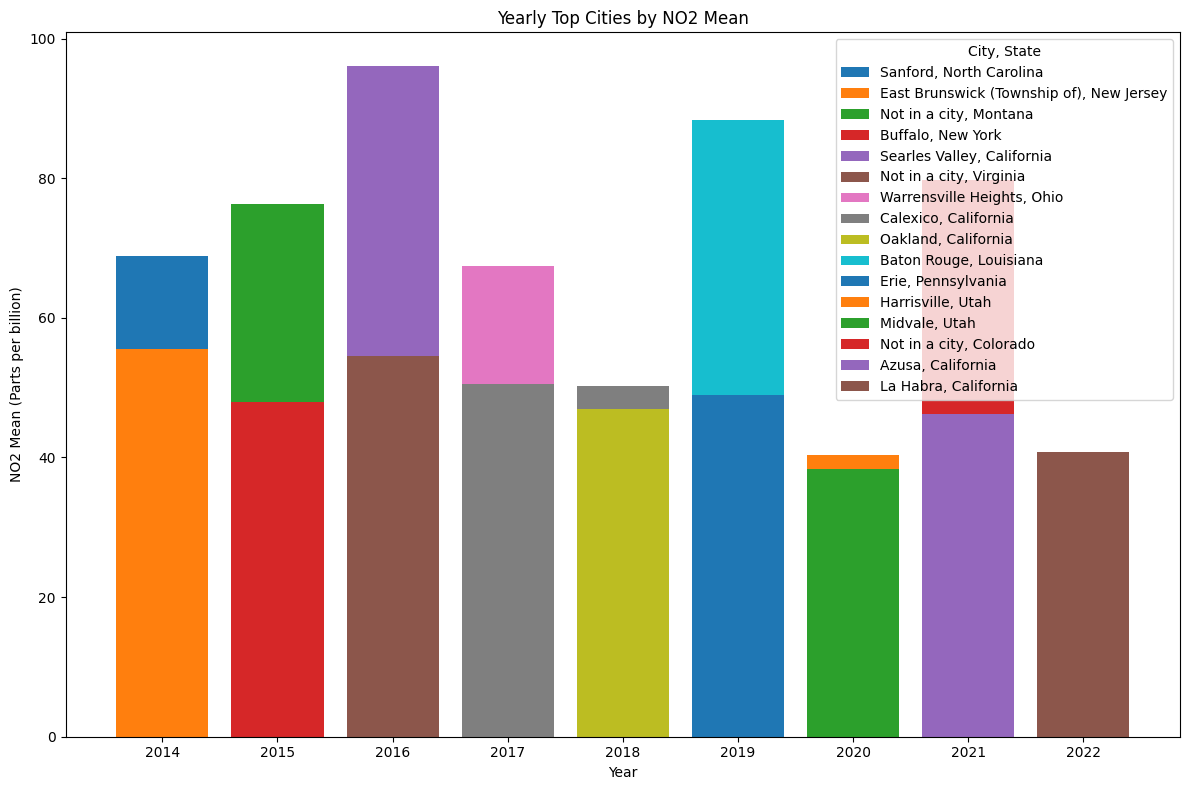

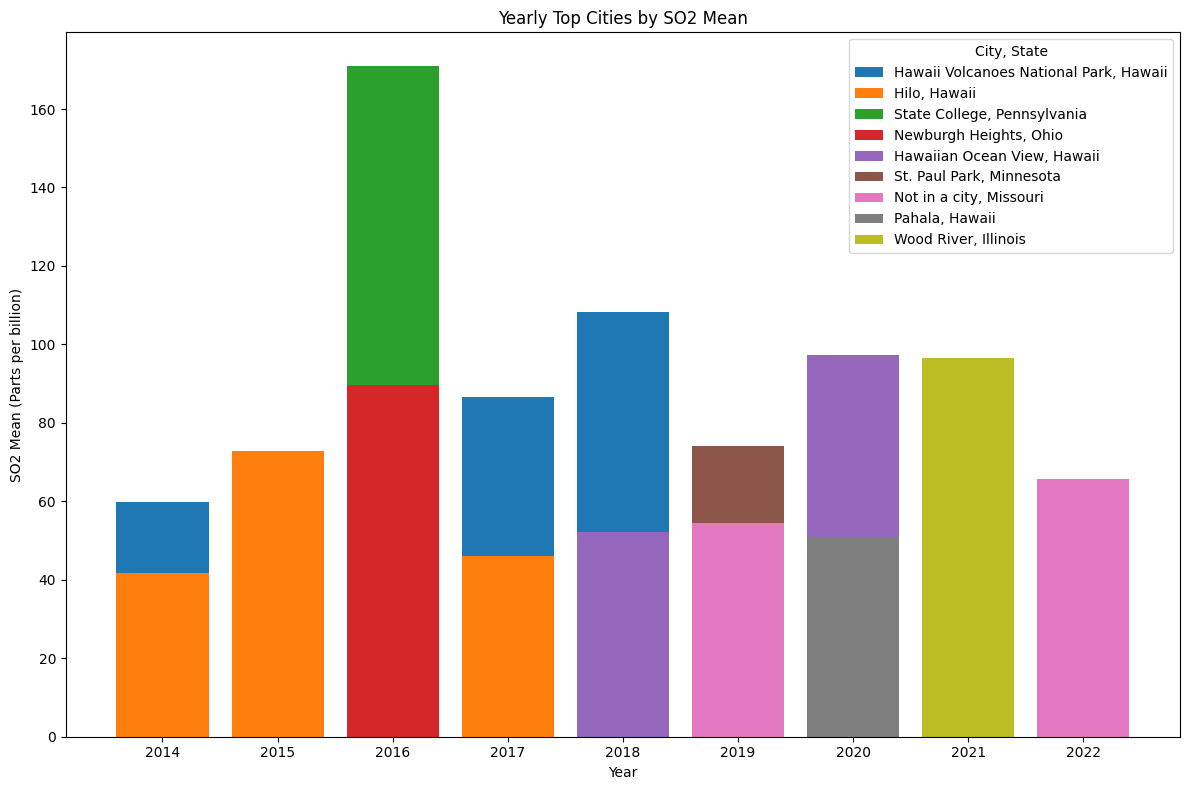

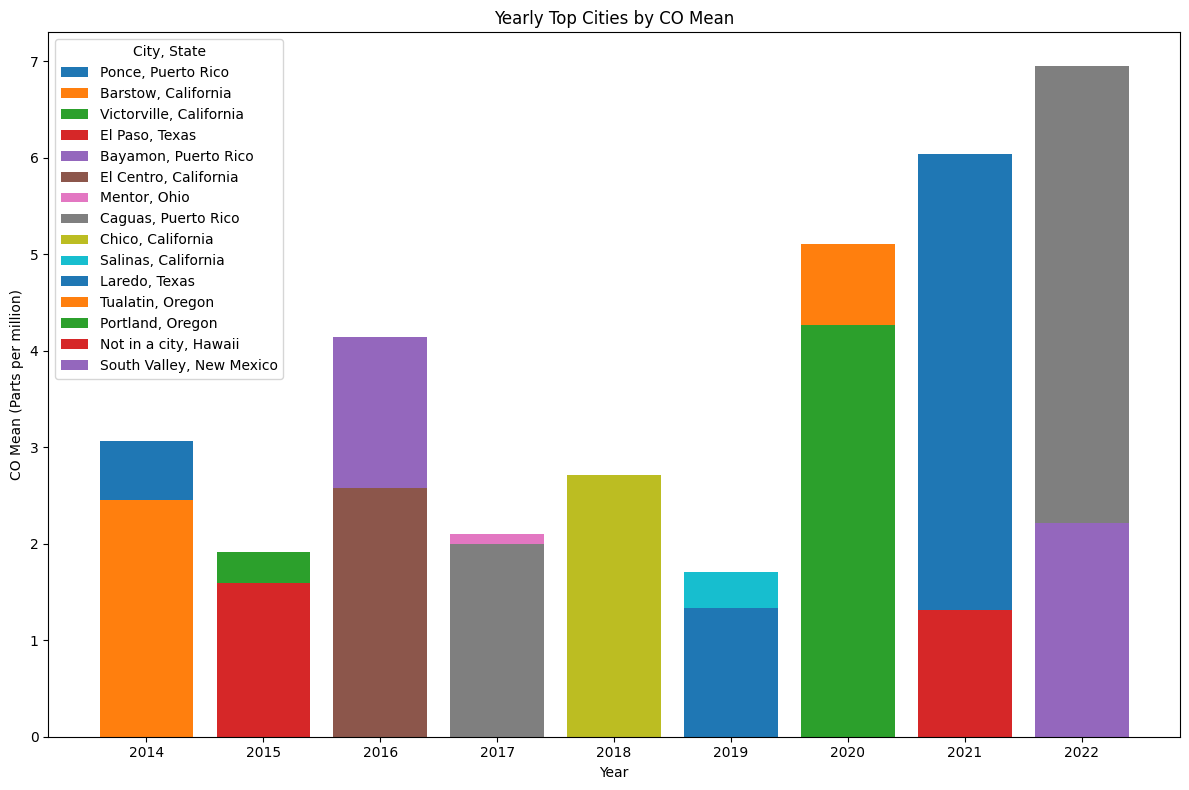

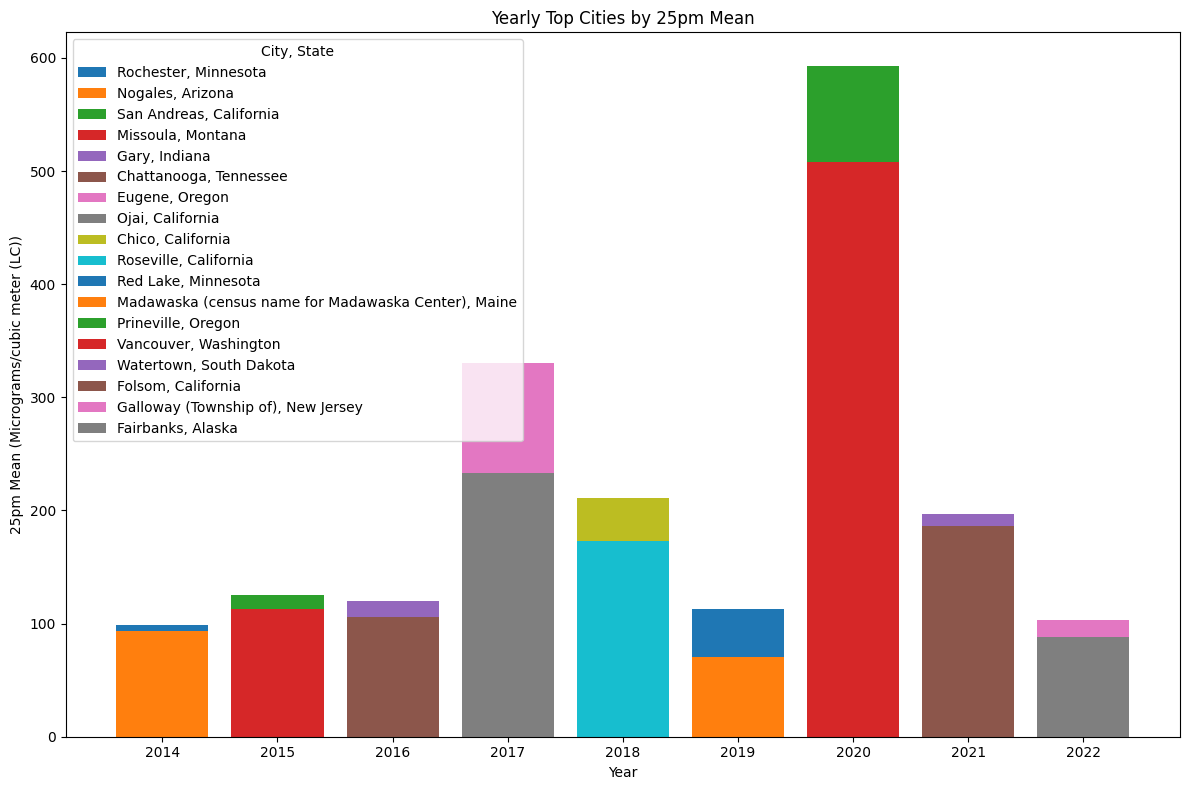

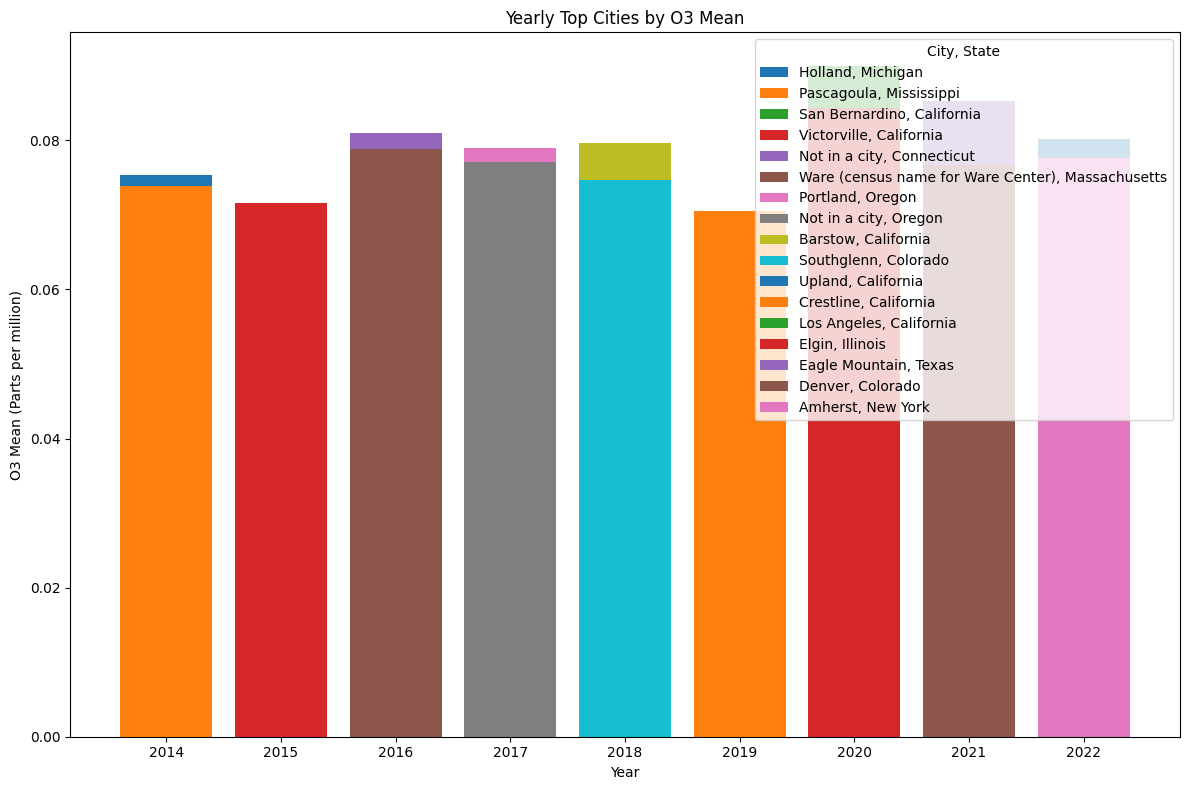

In [51]:


def plot_yearly_top_pollutants(yearly_top_df, pollutant_name):
    """
    Plot the top cities' yearly mean of the given pollutant.

    Args:
    - yearly_top_df: DataFrame with yearly top cities for the selected pollutant.
    - pollutant_name: The name of the pollutant (e.g., "NO2", "O3").
    
    Returns:
    A bar chart with "Year" on the x-axis, "{pollutant_name} Mean" values on the y-axis, and a legend denoting each unique "City, State" combination.
    """
    # Prepare data for plotting. We'll concatenate "City Name" and "State Name" for the legend:
    plot_data = yearly_top_df.withColumn("City_State", concat_ws(", ", "City Name", "State Name")).toPandas()
    
    # Extract the unique unit of measure for the given pollutant
    unit_of_measure = plot_data[f"Units of Measure {pollutant_name}"].iloc[0]

    fig, ax = plt.subplots(figsize=(12, 8))

    for city_state in plot_data["City_State"].unique():
        subset = plot_data[plot_data["City_State"] == city_state]
        ax.bar(subset["Year"], subset[f"{pollutant_name} Mean"], label=city_state)

    ax.set_xlabel("Year")
    ax.set_ylabel(f"{pollutant_name} Mean ({unit_of_measure})")
    ax.set_title(f"Yearly Top Cities by {pollutant_name} Mean")
    ax.legend(title="City, State")

    plt.xticks(plot_data["Year"].unique())  # Show all years on the x-axis
    plt.tight_layout()
    plt.show()


# Plot
plot_yearly_top_pollutants(yearly_top_NO2, 'NO2')
plot_yearly_top_pollutants(yearly_top_SO2, 'SO2')
plot_yearly_top_pollutants(yearly_top_CO, 'CO')
plot_yearly_top_pollutants(yearlyTop25PM, '25pm')
plot_yearly_top_pollutants(yearly_top_O3, 'O3')

#### Oh, Fairbanks is top 2 in 2022 2.5pm particulates

In [125]:
"""

newPM25 = PM25.select('Date Local', 'State Name', 'City Name', 'Arithmetic Mean', 'Units of Measure', 'AQI') \
                .withColumnRenamed('Arithmetic Mean', '25pm Mean') \
                    .withColumnRenamed('AQI', '25pm AQI')\
                    .withColumnRenamed('Units of Measure', 'Units of Measure 25pm')
                    
"""
daily_mean_all_PM25 = (newPM25
              .groupBy("Date Local", "City Name", "State Name")
              .agg(
                  F.avg("25pm Mean").alias("Average 2.5pm Mean"),
                  F.avg("25pm AQI").alias("2.5 AQI")
              )
              .orderBy("Date Local")
             )


In [141]:
from pyspark.sql.functions import col

filtered_df_fairbanks = newPM25.filter((col("City Name") == 'Fairbanks') & 
                             (col("State Name") == 'Alaska')) \
            .select("Date Local", "City Name", "State Name", "`25pm Mean`", "Units of Measure 25pm", "`25pm AQI`") \
            .withColumnRenamed('25pm AQI', 'avg(AQI)')


In [54]:
"""filtered_df_fairbanks_all = merged_df.filter((col("City Name") == 'Fairbanks') & 
                             (col("State Name") == 'Alaska')) \
            .select("Date Local", "City Name", "State Name", \
                    "CO Mean", "Units of Measure CO", \
                    "25pm Mean", "Units of Measure 25pm", \
                    "NO2 Mean", "Units of Measure NO2", \
                    "SO2 Mean", "Units of Measure SO2", \
                    "O3 Mean", "Units of Measure O3"              
                   )
"""

'filtered_df_fairbanks_all = merged_df.filter((col("City Name") == \'Fairbanks\') & \n                             (col("State Name") == \'Alaska\'))             .select("Date Local", "City Name", "State Name",                     "CO Mean", "Units of Measure CO",                     "25pm Mean", "Units of Measure 25pm",                     "NO2 Mean", "Units of Measure NO2",                     "SO2 Mean", "Units of Measure SO2",                     "O3 Mean", "Units of Measure O3"              \n                   )\n'

#### Meteorological conditions and AQI

In [55]:
"""
folder_path = "bigdata/aqi/"
aqi = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

folder_path = "bigdata/dew point/"
dew_point = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

folder_path = "bigdata/pressure/"
pressure = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

folder_path = "bigdata/temp/"
temperature = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)
"""
folder_path = "bigdata/wind/"
wind = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

In [56]:
wind.show(n=3, vertical=True)



-RECORD 0-----------------------------------
 State Code          | 1                    
 County Code         | 73                   
 Site Num            | 23                   
 Parameter Code      | 61103                
 POC                 | 1                    
 Latitude            | 33.553056            
 Longitude           | -86.815              
 Datum               | WGS84                
 Parameter Name      | Wind Speed - Resu... 
 Sample Duration     | 1 HOUR               
 Pollutant Standard  | null                 
 Date Local          | 2014-01-01           
 Units of Measure    | Knots                
 Event Type          | None                 
 Observation Count   | 24                   
 Observation Percent | 100.0                
 Arithmetic Mean     | 1.2                  
 1st Max Value       | 2.5                  
 1st Max Hour        | 21                   
 AQI                 | null                 
 Method Code         | 61                   
 Method Na

#### This is done to make distinct columns for Wind Speed and Wind Direction

In [57]:
wind = wind.select('Date Local', 'City Name', 'State Name', 'Parameter Name', 'Units of Measure', 'Arithmetic Mean')
wind_piv = wind.groupBy("Date Local", "City Name", 'State Name').pivot("Parameter Name").agg(F.first("Arithmetic Mean"))
                                                                                     
pivoted_units = wind.groupBy("Date Local", "City Name", "State Name").pivot("Parameter Name").agg(F.first("Units of Measure"))


In [58]:
wind_piv.columns

['Date Local',
 'City Name',
 'State Name',
 'Wind Direction - Resultant',
 'Wind Speed - Resultant']

In [59]:
wind_piv.orderBy('Date Local', 'State Name', 'City Name').show(n=3, vertical=True)

-RECORD 0-----------------------------------
 Date Local                 | 2014-01-01    
 City Name                  | Birmingham    
 State Name                 | Alabama       
 Wind Direction - Resultant | 107.666667    
 Wind Speed - Resultant     | 1.2           
-RECORD 1-----------------------------------
 Date Local                 | 2014-01-01    
 City Name                  | Fairbanks     
 State Name                 | Alaska        
 Wind Direction - Resultant | 286.041667    
 Wind Speed - Resultant     | 1.375         
-RECORD 2-----------------------------------
 Date Local                 | 2014-01-01    
 City Name                  | Not in a city 
 State Name                 | Alaska        
 Wind Direction - Resultant | 219.791667    
 Wind Speed - Resultant     | 1.829167      
only showing top 3 rows



In [60]:
pivoted_units.show()

+----------+-------------+--------------+--------------------------+----------------------+
|Date Local|    City Name|    State Name|Wind Direction - Resultant|Wind Speed - Resultant|
+----------+-------------+--------------+--------------------------+----------------------+
|2014-01-01|Not in a city|       Wyoming|           Degrees Compass|                 Knots|
|2014-01-01|        Tulsa|      Oklahoma|           Degrees Compass|                 Knots|
|2014-01-02|    St. Louis|      Missouri|           Degrees Compass|                 Knots|
|2014-01-05|  Porterville|    California|           Degrees Compass|                 Knots|
|2014-01-06|   Greenville|         Texas|           Degrees Compass|                 Knots|
|2014-01-06|    Kennewick|    Washington|           Degrees Compass|                 Knots|
|2014-01-07|       Clovis|    California|           Degrees Compass|                 Knots|
|2014-01-07|   Fort Wayne|       Indiana|           Degrees Compass|            

In [61]:
pivoted_units = pivoted_units.withColumnRenamed('Wind Direction - Resultant', 'Unit of Measure Direction') \
            .withColumnRenamed("Wind Speed - Resultant", 'Unit of Measure Speed')

pivoted_wind = wind_piv.join(pivoted_units, on=["Date Local", "City Name", "State Name"], how="inner")

pivoted_wind_final = pivoted_wind.select('Date Local', 'City Name', 'State Name',
 'Wind Direction - Resultant',
 'Unit of Measure Direction',
'Wind Speed - Resultant',
 'Unit of Measure Speed')

In [62]:
pivoted_wind_final.count()

1342248

In [63]:
merged_df.count()

237845

#### Merging wind dataframe with merged pollutants

In [64]:
merged_two = merged_df.join(pivoted_wind_final, on=["Date Local", "City Name", "State Name"], how="inner")

merged_two.show(n=3)

+----------+-------------+----------+-------------------+--------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------------------+-------------------------+----------------------+---------------------+
|Date Local|    City Name|State Name|            CO Mean|             O3 Mean|           O3 AQI|         NO2 mean|          NO2 AQI|         25pm Mean|          25pm AQI|          SO2 Mean|           SO2 AQI|Wind Direction - Resultant|Unit of Measure Direction|Wind Speed - Resultant|Unit of Measure Speed|
+----------+-------------+----------+-------------------+--------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------------------+-------------------------+----------------------+---------------------+
|2014-01-01|Not in a city|   Wyoming|0.18921549999999998| 0.03794109090909092|3

In [65]:
aqi = spark.read.csv("bigdata/aqi/" + "*.csv", header=True, inferSchema=True)

folder_path = "bigdata/dew point/"
dew_point = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

folder_path = "bigdata/pressure/"
pressure = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

folder_path = "bigdata/temp/"
temperature = spark.read.csv(folder_path + "*.csv", header=True, inferSchema=True)

#### Renaming  to avoid redundancy

In [66]:
new_dew = dew_point.select('Date Local', 'City Name', 'State Name', 'Units of Measure', 'Arithmetic Mean') \
.withColumnRenamed('Units of Measure', 'Units Dew Point') \
.withColumnRenamed('Arithmetic Mean', 'Dew Mean')
#rename

new_temperature = temperature.select('Date Local', 'City Name', 'State Name', 'Units of Measure', 'Arithmetic Mean', '1st Max Value') \
.withColumnRenamed('Units of Measure', 'Units Temperature') \
.withColumnRenamed('Arithmetic Mean', 'Temp Mean') \
.withColumnRenamed('1st Max Value', 'Max Temp')

new_pressure = pressure.select('Date Local', 'City Name', 'State Name', 'Units of Measure', 'Arithmetic Mean') \
.withColumnRenamed('Units of Measure', 'Units Pressure') \
.withColumnRenamed('Arithmetic Mean', 'Pressure Mean')

#Rename county Name to City Name:for data purposes, decreases precision
new_aqi = aqi.select('Date', 'State Name', 'county Name', 'AQI').withColumnRenamed('county Name', 'City Name') \
                                                        .withColumnRenamed('Date', 'Date Local')

#### Now merging meteorological conditions and AQI

In [67]:
# Join new_dew and new_temperature
joined_df = new_dew.join(new_temperature, on=['Date Local', 'City Name', 'State Name'], how='inner')

# Join the resulting DataFrame with new_pressure
joined_df = joined_df.join(new_pressure, on=['Date Local', 'City Name', 'State Name'], how='inner')

# Join the resulting DataFrame with new_aqi
joined_df = joined_df.join(new_aqi, on=['Date Local', 'City Name', 'State Name'], how='inner')

# Show the resulting DataFrame
joined_df.show()


+----------+---------+----------+--------------------+---------+------------------+---------+--------+--------------+-------------+---+
|Date Local|City Name|State Name|     Units Dew Point| Dew Mean| Units Temperature|Temp Mean|Max Temp|Units Pressure|Pressure Mean|AQI|
+----------+---------+----------+--------------------+---------+------------------+---------+--------+--------------+-------------+---+
|2014-02-02| New York|  New York|Percent relative ...|     70.0|Degrees Fahrenheit|    43.75|    54.0|     Millibars|  1008.916667| 76|
|2014-02-02| New York|  New York|Percent relative ...|     70.0|Degrees Fahrenheit|    43.75|    54.0|     Millibars|     1010.875| 76|
|2014-02-02| New York|  New York|Percent relative ...|     70.0|Degrees Fahrenheit|    43.75|    54.0|     Millibars|  1002.958333| 76|
|2014-02-02| New York|  New York|Percent relative ...|     70.0|Degrees Fahrenheit|    44.25|    55.0|     Millibars|  1008.916667| 76|
|2014-02-02| New York|  New York|Percent relativ

#### Computing averages 

In [68]:
joined_df = joined_df.groupby('Date Local', 'State Name', 'City Name').avg()
joined_df = joined_df.orderBy('Date Local', 'State Name', 'City Name')

In [69]:
joined_df.show(n=5, vertical=True)

-RECORD 0--------------------------------
 Date Local         | 2014-01-01         
 State Name         | California         
 City Name          | Los Angeles        
 avg(Dew Mean)      | 50.833333          
 avg(Temp Mean)     | 57.5875            
 avg(Max Temp)      | 71.3               
 avg(Pressure Mean) | 1007.125           
 avg(AQI)           | 161.0              
-RECORD 1--------------------------------
 Date Local         | 2014-01-01         
 State Name         | California         
 City Name          | Madera             
 avg(Dew Mean)      | 57.291666500000005 
 avg(Temp Mean)     | 46.9791665         
 avg(Max Temp)      | 63.0               
 avg(Pressure Mean) | 1011.7145834999999 
 avg(AQI)           | 152.0              
-RECORD 2--------------------------------
 Date Local         | 2014-01-01         
 State Name         | California         
 City Name          | San Diego          
 avg(Dew Mean)      | 55.208333          
 avg(Temp Mean)     | 55.777777666

#### Merging wind and pollutants with the remaining meteorological information

In [71]:
joined_df = joined_df.join(merged_two, on=['Date Local', 'City Name', 'State Name'], how='inner')

In [72]:
joined_df.columns

['Date Local',
 'City Name',
 'State Name',
 'avg(Dew Mean)',
 'avg(Temp Mean)',
 'avg(Max Temp)',
 'avg(Pressure Mean)',
 'avg(AQI)',
 'CO Mean',
 'O3 Mean',
 'O3 AQI',
 'NO2 mean',
 'NO2 AQI',
 '25pm Mean',
 '25pm AQI',
 'SO2 Mean',
 'SO2 AQI',
 'Wind Direction - Resultant',
 'Unit of Measure Direction',
 'Wind Speed - Resultant',
 'Unit of Measure Speed']

In [73]:
joined_df = joined_df.dropna()

In [74]:
joined_df.show(n=5, vertical=True)

-RECORD 0------------------------------------------
 Date Local                 | 2014-02-02           
 City Name                  | New York             
 State Name                 | New York             
 avg(Dew Mean)              | 70.0                 
 avg(Temp Mean)             | 43.958333333333336   
 avg(Max Temp)              | 55.0                 
 avg(Pressure Mean)         | 1007.5833333333334   
 avg(AQI)                   | 76.0                 
 CO Mean                    | 0.8057914999999998   
 O3 Mean                    | 0.009485249999999999 
 O3 AQI                     | 10.25                
 NO2 mean                   | 39.03749966666666    
 NO2 AQI                    | 52.0                 
 25pm Mean                  | 24.162499999999998   
 25pm AQI                   | 76.0                 
 SO2 Mean                   | 4.543055666666667    
 SO2 AQI                    | 12.0                 
 Wind Direction - Resultant | 220.375              
 Unit of Mea

In [75]:
joined_df.orderBy('State Name', 'City Name').show(n=5 vertical=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [76]:
joined_df.select('City Name').distinct().count()

7

In [77]:
joined_df.select('City Name').distinct().collect()

[Row(City Name='Dallas'),
 Row(City Name='Rutland'),
 Row(City Name='Los Angeles'),
 Row(City Name='El Paso'),
 Row(City Name='Fresno'),
 Row(City Name='New Haven'),
 Row(City Name='New York')]

In [78]:
joined_df.printSchema()

root
 |-- Date Local: string (nullable = true)
 |-- City Name: string (nullable = true)
 |-- State Name: string (nullable = true)
 |-- avg(Dew Mean): double (nullable = true)
 |-- avg(Temp Mean): double (nullable = true)
 |-- avg(Max Temp): double (nullable = true)
 |-- avg(Pressure Mean): double (nullable = true)
 |-- avg(AQI): double (nullable = true)
 |-- CO Mean: double (nullable = true)
 |-- O3 Mean: double (nullable = true)
 |-- O3 AQI: double (nullable = true)
 |-- NO2 mean: double (nullable = true)
 |-- NO2 AQI: double (nullable = true)
 |-- 25pm Mean: double (nullable = true)
 |-- 25pm AQI: double (nullable = true)
 |-- SO2 Mean: double (nullable = true)
 |-- SO2 AQI: double (nullable = true)
 |-- Wind Direction - Resultant: double (nullable = true)
 |-- Unit of Measure Direction: string (nullable = true)
 |-- Wind Speed - Resultant: double (nullable = true)
 |-- Unit of Measure Speed: string (nullable = true)



#### Filtering by city

In [82]:
from pyspark.sql.functions import col

In [224]:
filtered_la_all = joined_df.filter((col("City Name") == 'Los Angeles') & 
                             (col("State Name") == 'California'))

filtered_la_all = filtered_la_all.orderBy('Date Local')

In [225]:
filtered_df_ny_all = joined_df.filter((col("City Name") == 'New York') & 
                             (col("State Name") == 'New York'))

filtered_df_ny_all = filtered_df_ny_all.orderBy('Date Local')

#### Conversion to pandas for plotting

In [208]:
ny_to_plot = filtered_df_ny_all.select('Date Local', 'City Name', 'State Name', 'avg(AQI)').orderBy('Date Local').toPandas()

la_to_plot = filtered_la_all.select('Date Local', 'City Name', 'State Name', 'avg(AQI)').orderBy('Date Local').toPandas()

In [209]:
la_to_plot.head()

,Date Local,City Name,State Name,avg(AQI)
0,2014-01-01,Los Angeles,California,161.0
1,2014-01-02,Los Angeles,California,111.0
2,2014-01-03,Los Angeles,California,84.0
3,2014-01-04,Los Angeles,California,118.0
4,2014-01-05,Los Angeles,California,97.0


In [210]:
ny_to_plot.head()

,Date Local,City Name,State Name,avg(AQI)
0,2014-01-01,New York,New York,59.0
1,2014-01-02,New York,New York,76.0
2,2014-01-03,New York,New York,57.0
3,2014-01-04,New York,New York,56.0
4,2014-01-05,New York,New York,80.0


In [145]:
def plot_df(df):
    #Plot
    plt.figure(); df.plot(kind='line', figsize=(18, 6), x='Date Local',y='avg(AQI)',color='orange')
    
    from matplotlib.dates import MonthLocator
    plt.gca().xaxis.set_major_locator(MonthLocator(interval=3))

    # Set X axis major tick formatters to be month names
    from matplotlib.dates import DateFormatter
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))
    
    plt.tight_layout()
    plt.show()

### Los Angeles

<Figure size 640x480 with 0 Axes>

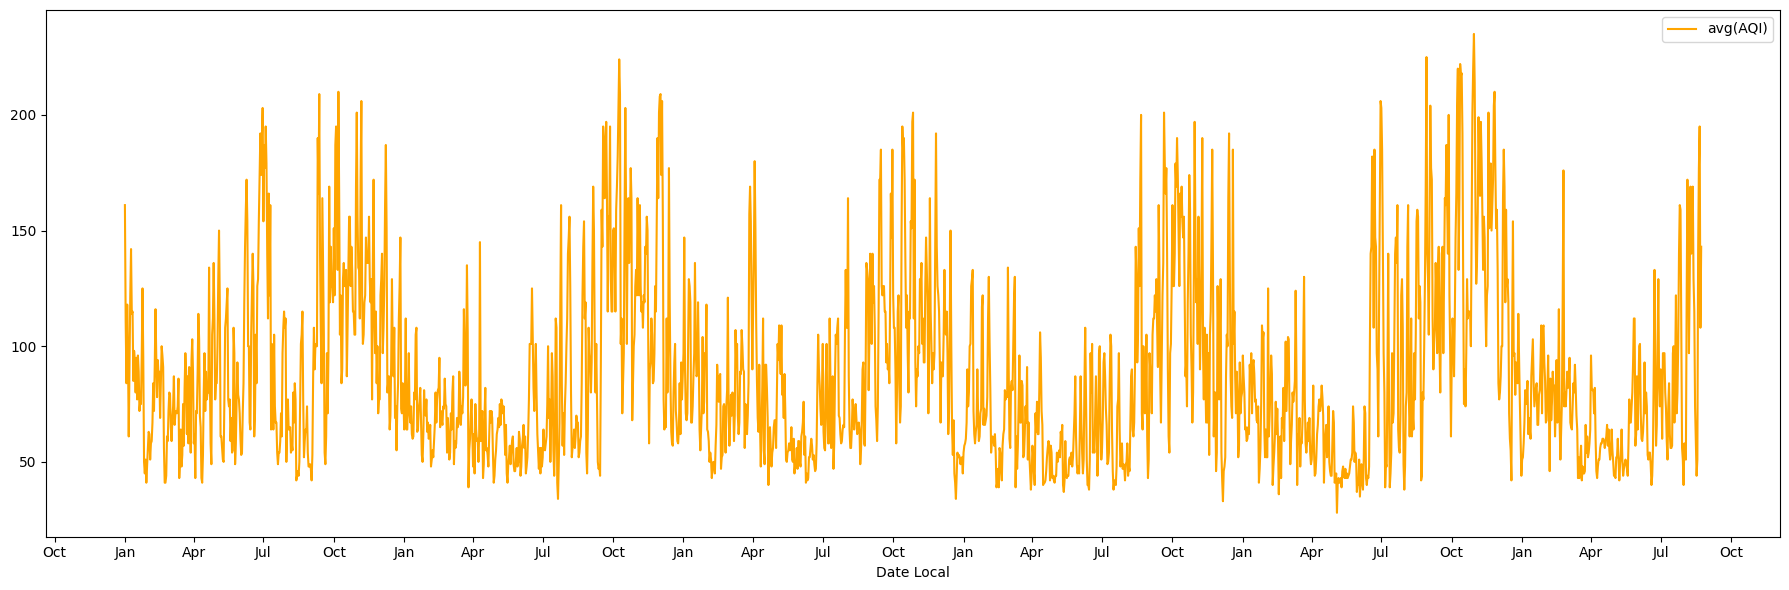

In [123]:
plot_df(la_to_plot)

### New York

<Figure size 640x480 with 0 Axes>

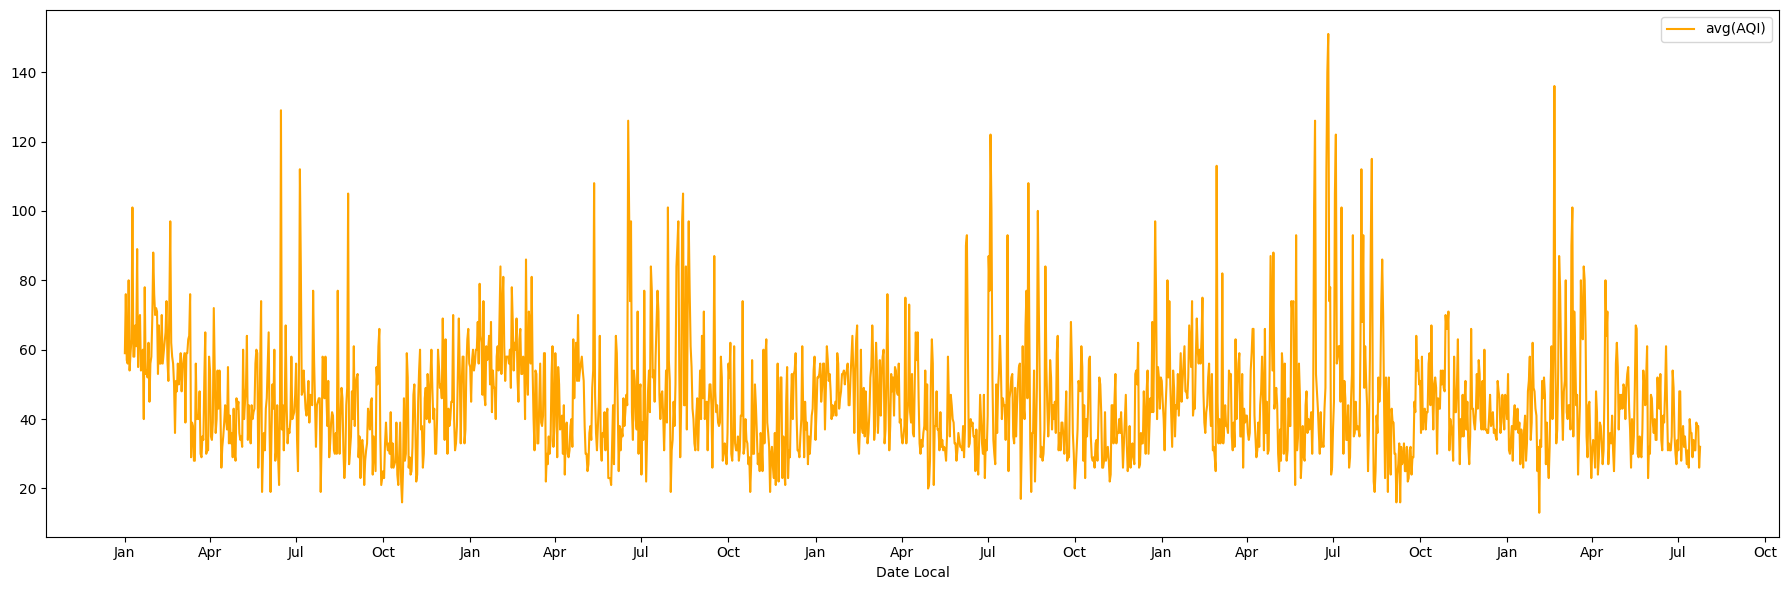

In [90]:
plot_df(ny_to_plot)

In [131]:
fairbanks_plot.head

<bound method NDFrame.head of       Date Local  City Name State Name  25pm Mean  \
0     2014-01-02  Fairbanks     Alaska       10.0   
1     2014-01-02  Fairbanks     Alaska       12.4   
2     2014-01-05  Fairbanks     Alaska       14.2   
3     2014-01-05  Fairbanks     Alaska       14.2   
4     2014-01-05  Fairbanks     Alaska       14.6   
...          ...        ...        ...        ...   
4805  2022-06-28  Fairbanks     Alaska      216.8   
4806  2022-06-28  Fairbanks     Alaska      230.2   
4807  2022-06-28  Fairbanks     Alaska      215.6   
4808  2022-06-30  Fairbanks     Alaska       94.5   
4809  2022-06-30  Fairbanks     Alaska       84.2   

            Units of Measure 25pm  25pm AQI  
0     Micrograms/cubic meter (LC)        42  
1     Micrograms/cubic meter (LC)        52  
2     Micrograms/cubic meter (LC)        55  
3     Micrograms/cubic meter (LC)        55  
4     Micrograms/cubic meter (LC)        56  
...                           ...       ...  
4805  Micro

### Fairbanks

In [143]:
fairbanks_plot = filtered_df_fairbanks.orderBy('Date Local').toPandas()

<Figure size 640x480 with 0 Axes>

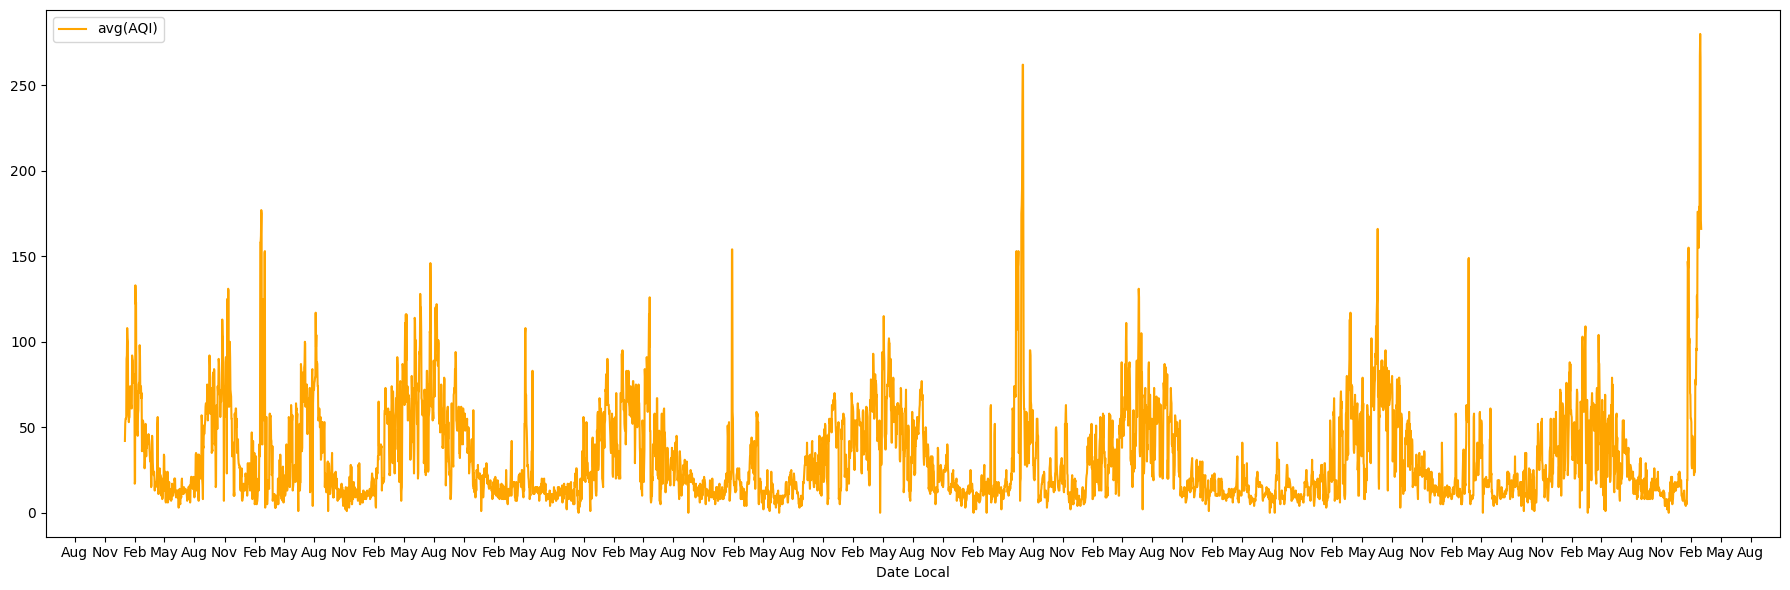

In [160]:
plot_df(fairbanks_plot)

In [226]:
filtered_la_all.columns

['Date Local',
 'City Name',
 'State Name',
 'avg(Dew Mean)',
 'avg(Temp Mean)',
 'avg(Max Temp)',
 'avg(Pressure Mean)',
 'avg(AQI)',
 'CO Mean',
 'O3 Mean',
 'O3 AQI',
 'NO2 mean',
 'NO2 AQI',
 '25pm Mean',
 '25pm AQI',
 'SO2 Mean',
 'SO2 AQI',
 'Wind Direction - Resultant',
 'Unit of Measure Direction',
 'Wind Speed - Resultant',
 'Unit of Measure Speed']

In [228]:
filtered_df_ny_all.columns

['Date Local',
 'City Name',
 'State Name',
 'avg(Dew Mean)',
 'avg(Temp Mean)',
 'avg(Max Temp)',
 'avg(Pressure Mean)',
 'avg(AQI)',
 'CO Mean',
 'O3 Mean',
 'O3 AQI',
 'NO2 mean',
 'NO2 AQI',
 '25pm Mean',
 '25pm AQI',
 'SO2 Mean',
 'SO2 AQI',
 'Wind Direction - Resultant',
 'Unit of Measure Direction',
 'Wind Speed - Resultant',
 'Unit of Measure Speed']

## Feature Selection

#### Day of the Week

In [ ]:

filtered_df_ny_all.select('Date Local').show()

In [220]:


# Assuming filtered_df_ny_all has a column 'Date Local' in format 'YYYY-MM-DD'
# Extract year, month and day

def extract_days(df):
    
    from pyspark.sql import functions as F

    filtered_df_ny_all = df.withColumn('Year', F.year('Date Local'))
    filtered_df_ny_all = filtered_df_ny_all.withColumn('Month', F.month('Date Local'))
    filtered_df_ny_all = filtered_df_ny_all.withColumn('Day', F.dayofmonth('Date Local'))

# Construct new columns: 'YYMM' and 'Day'
    filtered_df_ny_all = filtered_df_ny_all.withColumn('YYMM', 
                            F.concat(F.substring('Year', 3, 2), F.lpad('Month', 2, '0')))
    filtered_df_ny_all = filtered_df_ny_all.withColumn('Day', F.lpad('Day', 2, '0'))

    filtered_df_ny_all.select('Date Local', 'YYMM', 'Day').show()


    filtered_df_ny_all.show(n=5, vertical=True)

    filtered_df_ny_all.printSchema()


    from pyspark.sql import functions as F
    
    # Use dayofweek to get the day of the week as integer (Sunday=1 to Saturday=7)
    filtered_df_ny_all = filtered_df_ny_all.withColumn('Weekday_Int', 
                                                   F.when(F.dayofweek('Date Local') == 1, 7)
                                                    .otherwise(F.dayofweek('Date Local') - 1))

    filtered_df_ny_all.select('Date Local', 'YYMM', 'Day', 'Weekday_Int').show()
    
    return filtered_df_ny_all


In [229]:
#filtered_la_all = extract_days(filtered_la_all)
filtered_df_ny_extracted = extract_days(filtered_df_ny_all)


+----------+----+---+
|Date Local|YYMM|Day|
+----------+----+---+
|2014-01-01|1401| 01|
|2014-01-02|1401| 02|
|2014-01-03|1401| 03|
|2014-01-04|1401| 04|
|2014-01-05|1401| 05|
|2014-01-07|1401| 07|
|2014-01-08|1401| 08|
|2014-01-09|1401| 09|
|2014-01-10|1401| 10|
|2014-01-11|1401| 11|
|2014-01-12|1401| 12|
|2014-01-13|1401| 13|
|2014-01-14|1401| 14|
|2014-01-15|1401| 15|
|2014-01-16|1401| 16|
|2014-01-17|1401| 17|
|2014-01-18|1401| 18|
|2014-01-19|1401| 19|
|2014-01-20|1401| 20|
|2014-01-21|1401| 21|
+----------+----+---+
only showing top 20 rows

-RECORD 0------------------------------------------
 Date Local                 | 2014-01-01           
 City Name                  | New York             
 State Name                 | New York             
 avg(Dew Mean)              | 66.333333            
 avg(Temp Mean)             | 28.888888666666666   
 avg(Max Temp)              | 32.666666666666664   
 avg(Pressure Mean)         | 1020.125000333333    
 avg(AQI)                   | 

In [239]:
filtered_df_la_extracted = extract_days(filtered_la_all)

+----------+----+---+
|Date Local|YYMM|Day|
+----------+----+---+
|2014-01-01|1401| 01|
|2014-01-02|1401| 02|
|2014-01-03|1401| 03|
|2014-01-04|1401| 04|
|2014-01-05|1401| 05|
|2014-01-06|1401| 06|
|2014-01-08|1401| 08|
|2014-01-09|1401| 09|
|2014-01-10|1401| 10|
|2014-01-11|1401| 11|
|2014-01-12|1401| 12|
|2014-01-15|1401| 15|
|2014-01-16|1401| 16|
|2014-01-17|1401| 17|
|2014-01-18|1401| 18|
|2014-01-19|1401| 19|
|2014-01-22|1401| 22|
|2014-01-23|1401| 23|
|2014-01-24|1401| 24|
|2014-01-25|1401| 25|
+----------+----+---+
only showing top 20 rows

-RECORD 0------------------------------------------
 Date Local                 | 2014-01-01           
 City Name                  | Los Angeles          
 State Name                 | California           
 avg(Dew Mean)              | 50.833333            
 avg(Temp Mean)             | 57.5875              
 avg(Max Temp)              | 71.3                 
 avg(Pressure Mean)         | 1007.125             
 avg(AQI)                   | 

In [340]:
filtered_df_ny_extracted.columns

['Date Local',
 'City Name',
 'State Name',
 'avg(Dew Mean)',
 'avg(Temp Mean)',
 'avg(Max Temp)',
 'avg(Pressure Mean)',
 'avg(AQI)',
 'CO Mean',
 'O3 Mean',
 'O3 AQI',
 'NO2 mean',
 'NO2 AQI',
 '25pm Mean',
 '25pm AQI',
 'SO2 Mean',
 'SO2 AQI',
 'Wind Direction - Resultant',
 'Unit of Measure Direction',
 'Wind Speed - Resultant',
 'Unit of Measure Speed',
 'Year',
 'Month',
 'Day',
 'YYMM',
 'Weekday_Int']

#### Encoding the days

In [232]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


def encode(df):

# Convert Weekday_Int to a string to treat it as categorical
    filtered_df_ny_all = df.withColumn('Weekday_Str', F.col('Weekday_Int').cast('string'))

# Use StringIndexer to convert Weekday_Str to an index
    indexer = StringIndexer(inputCol="Weekday_Str", outputCol="Weekday_Index")

# Use OneHotEncoder to one-hot encode the Weekday_Index
    encoder = OneHotEncoder(inputCol="Weekday_Index", outputCol="Weekday_OHE")

# Set up the pipeline
    pipeline = Pipeline(stages=[indexer, encoder])

# Fit and transform the data
    filtered_df_ny_all = pipeline.fit(filtered_df_ny_all).transform(filtered_df_ny_all)

# Show the results
    filtered_df_ny_all.select('Date Local', 'Weekday_Int', 'Weekday_Str', 'Weekday_Index', 'Weekday_OHE').show()
    
    #filtered_df_ny_all = filtered_df_ny_all.join(x, on='Date Local', how='inner')
    
    return filtered_df_ny_all#.select('Date Local', 'Weekday_Int', 'Weekday_Str', 'Weekday_Index', 'Weekday_OHE')


In [233]:
filtered_df_ny_last = encode(filtered_df_ny_extracted) 

+----------+-----------+-----------+-------------+-------------+
|Date Local|Weekday_Int|Weekday_Str|Weekday_Index|  Weekday_OHE|
+----------+-----------+-----------+-------------+-------------+
|2014-01-01|          3|          3|          2.0|(6,[2],[1.0])|
|2014-01-02|          4|          4|          3.0|(6,[3],[1.0])|
|2014-01-03|          5|          5|          5.0|(6,[5],[1.0])|
|2014-01-04|          6|          6|          4.0|(6,[4],[1.0])|
|2014-01-05|          7|          7|          6.0|    (6,[],[])|
|2014-01-07|          2|          2|          0.0|(6,[0],[1.0])|
|2014-01-08|          3|          3|          2.0|(6,[2],[1.0])|
|2014-01-09|          4|          4|          3.0|(6,[3],[1.0])|
|2014-01-10|          5|          5|          5.0|(6,[5],[1.0])|
|2014-01-11|          6|          6|          4.0|(6,[4],[1.0])|
|2014-01-12|          7|          7|          6.0|    (6,[],[])|
|2014-01-13|          1|          1|          1.0|(6,[1],[1.0])|
|2014-01-14|          2| 

In [240]:
filtered_la_last = encode(filtered_df_la_extracted)

+----------+-----------+-----------+-------------+-------------+
|Date Local|Weekday_Int|Weekday_Str|Weekday_Index|  Weekday_OHE|
+----------+-----------+-----------+-------------+-------------+
|2014-01-01|          3|          3|          2.0|(6,[2],[1.0])|
|2014-01-02|          4|          4|          3.0|(6,[3],[1.0])|
|2014-01-03|          5|          5|          4.0|(6,[4],[1.0])|
|2014-01-04|          6|          6|          0.0|(6,[0],[1.0])|
|2014-01-05|          7|          7|          1.0|(6,[1],[1.0])|
|2014-01-06|          1|          1|          5.0|(6,[5],[1.0])|
|2014-01-08|          3|          3|          2.0|(6,[2],[1.0])|
|2014-01-09|          4|          4|          3.0|(6,[3],[1.0])|
|2014-01-10|          5|          5|          4.0|(6,[4],[1.0])|
|2014-01-11|          6|          6|          0.0|(6,[0],[1.0])|
|2014-01-12|          7|          7|          1.0|(6,[1],[1.0])|
|2014-01-15|          3|          3|          2.0|(6,[2],[1.0])|
|2014-01-16|          4| 

In [362]:
filtered_LA_date = filtered_la_last.filter((col("Date Local") >= "2021-01-01") & (col("Date Local") <= "2022-06-01"))

In [366]:
filtered_LA_date_f = filtered_LA_date.orderBy('Date Local')

### Meteorological Data Features

In [332]:
def no_co2_transform(df):
    excluded_cols = ['Units Dew Point', 'Units Temperature', 'Units Pressure', 'Units of Measure CO', 
                 'Units of Measure O3', 'Units of Measure NO2', 'Units of Measure 25pm',
                 'Units of Measure SO2', 'Unit of Measure Direction', 'Unit of Measure Speed', '25pm AQI', 
                'NO2 AQI', 'O3 AQI','Weekday_Int', 'Weekday_Str', 'Weekday_Index', 'YYMM', 'Day']

    # Assuming 'final_merged' is your dataframe and you want all columns except the target and excluded ones as features
    features = [x for x in df.columns if x not in excluded_cols + ['avg(AQI)', 'Date Local', 'City Name', 'State Name']]

    if "features" not in df.columns:  # Check if features column already exists
        vectorAssembler = VectorAssembler(
            inputCols=features, 
            outputCol="features"
        )
        df = vectorAssembler.transform(df)
        
    return df, features


In [295]:
df_ny, features_ny_last = no_co2_transform(filtered_df_ny_last)

In [296]:
df_ny.show(n=3, vertical=True)

-RECORD 0------------------------------------------
 Date Local                 | 2014-01-01           
 City Name                  | New York             
 State Name                 | New York             
 avg(Dew Mean)              | 66.333333            
 avg(Temp Mean)             | 28.888888666666666   
 avg(Max Temp)              | 32.666666666666664   
 avg(Pressure Mean)         | 1020.125000333333    
 avg(AQI)                   | 59.0                 
 CO Mean                    | 0.3972262499999999   
 O3 Mean                    | 0.009059             
 O3 AQI                     | 14.75                
 NO2 mean                   | 21.494444666666666   
 NO2 AQI                    | 29.0                 
 25pm Mean                  | 14.0                 
 25pm AQI                   | 55.0                 
 SO2 Mean                   | 3.6736109999999993   
 SO2 AQI                    | 9.0                  
 Wind Direction - Resultant | 211.583333           
 Unit of Mea

In [297]:
df_la, features_la_last = no_co2_transform(filtered_la_last)

In [298]:
df_la.show(n=3, vertical=True)

-RECORD 0------------------------------------------
 Date Local                 | 2014-01-01           
 City Name                  | Los Angeles          
 State Name                 | California           
 avg(Dew Mean)              | 50.833333            
 avg(Temp Mean)             | 57.5875              
 avg(Max Temp)              | 71.3                 
 avg(Pressure Mean)         | 1007.125             
 avg(AQI)                   | 161.0                
 CO Mean                    | 1.2159905000000002   
 O3 Mean                    | 0.014608999999999999 
 O3 AQI                     | 22.0                 
 NO2 mean                   | 43.5948055           
 NO2 AQI                    | 67.5                 
 25pm Mean                  | 59.9                 
 25pm AQI                   | 153.0                
 SO2 Mean                   | 0.99848475           
 SO2 AQI                    | 5.0                  
 Wind Direction - Resultant | 110.083333           
 Unit of Mea

#### Path to CO2 emissions file and more merging

In [204]:
file_path_emissions_la = "/home/nmart001/data_cw2/pol2/meteo/bigdata/carbon-monitor-carbonmonitorCITIES-Los Angeles (Greater).xlsx"
file_path_emissions_ny = "/home/nmart001/data_cw2/ny.xlsx"

def emissions_to_merge(file_path):
    
    df_emissions = pd.read_excel(file_path)
    df_emissions = df_emissions.dropna()

    columns = ["city", "date", "sector", "ktCO2 per day"] 
 
    spark_df_emissions = spark.createDataFrame(df_emissions.values.tolist(), schema= columns)
    #spark_df_emissions.show()



# Assuming df_unpivoted is your unpivoted dataframe
    spark_df_emissions = spark_df_emissions.withColumn(
        "date",
        F.from_unixtime(F.unix_timestamp("date", "MM/dd/yyyy"), "dd/MM/yyyy")
    )


    df_pivot_emissions = spark_df_emissions.groupBy("city", "date").pivot("sector").sum("ktCO2 per day")
    df_pivot_emissions = df_pivot_emissions.orderBy('Date')
    df_emissions_final = df_pivot_emissions.select('date', 'city', 'Aviation', 'Ground Transport', 'Industry', 'Power', 'Residential') \
                    .withColumnRenamed('date', 'Date Local') \
                    .withColumnRenamed('city', 'City Name')

#df_emissions_final.show(n=800)
    df_emissions_final = df_emissions_final.withColumn("City Name", when(df_emissions_final["City Name"].startswith("Los Angeles (Grea"), "Los Angeles").otherwise(df_emissions_final["City Name"]))
    df_emissions_final = df_emissions_final.dropna()

# Show the resulting DataFrame
    df_emissions_final.printSchema
    
    df_emissions_final = df_emissions_final.withColumn("Date Local", to_date(col("Date Local"), "MM/dd/yyyy"))
    
    df_emissions_final.show()
    
    return df_emissions_final



#### LA pre-merging

In [183]:
la_to_merge = emissions_to_merge(file_path_emissions_la)

+----------+-----------+--------+----------------+--------+-------+-----------+
|Date Local|  City Name|Aviation|Ground Transport|Industry|  Power|Residential|
+----------+-----------+--------+----------------+--------+-------+-----------+
|2021-01-01|Los Angeles| 10.5723|         103.794| 157.886|40.2544|    125.499|
|2022-01-01|Los Angeles|  10.826|         52.2472| 121.053|29.1092|    139.735|
|2021-01-02|Los Angeles| 10.3785|         103.045| 158.682|39.9775|    123.268|
|2022-01-02|Los Angeles| 13.5157|          59.718| 135.985|35.4631|    177.746|
|2021-01-03|Los Angeles| 10.0574|         102.491|  159.48| 40.112|    121.959|
|2022-01-03|Los Angeles| 14.5659|         56.3604|  145.66|40.2772|    218.058|
|2021-01-04|Los Angeles| 9.96731|         103.412|  160.86|40.7535|    122.039|
|2022-01-04|Los Angeles| 14.6165|         58.0421| 137.966|37.8034|    210.402|
|2021-01-05|Los Angeles| 10.3573|         106.027| 163.286| 42.254|    126.856|
|2022-01-05|Los Angeles| 13.8684|       

#### NY pre-merging

In [205]:
ny_to_merge = emissions_to_merge(file_path_emissions_ny)

+----------+------------------+--------+----------------+--------+-------+-----------+
|Date Local|         City Name|Aviation|Ground Transport|Industry|  Power|Residential|
+----------+------------------+--------+----------------+--------+-------+-----------+
|2021-01-01|New York (Greater)| 7.44088|         79.2786| 116.192|51.2827|    148.364|
|2022-01-01|New York (Greater)| 8.84045|         32.7337| 90.4727| 50.605|    118.998|
|2021-01-02|New York (Greater)| 7.34275|         78.7071| 116.796|51.0192|    146.915|
|2022-01-02|New York (Greater)| 10.6883|         37.4142| 101.632|61.6509|    151.368|
|2021-01-03|New York (Greater)| 7.17154|         78.2846| 117.401|51.2772|    146.171|
|2022-01-03|New York (Greater)| 11.0288|         35.3106| 108.863|70.0201|    185.698|
|2021-01-04|New York (Greater)| 7.15687|         78.9885| 118.435|52.1881|    146.661|
|2022-01-04|New York (Greater)| 10.8362|         36.3643| 103.113|65.7196|    179.178|
|2021-01-05|New York (Greater)| 7.41931|   

#### CO2 with city merger function

In [203]:
#df_emissions_final = df_emissions_final.withColumn("Date Local", to_date(col("Date Local"), "MM/dd/yyyy"))

def joined_emissions(a, b):
    
    """
    Takes a: filtered_city_emssions
          b: df_emissions_final
    """
    """filtered_la_all"""
    """df_emissions_final"""
    
    filteredLAdate = a.filter((col("Date Local") >= "2021-01-01") & (col("Date Local") <= "2022-06-01"))
    #filteredLAdate.show(n=5, vertical=True)
    
    joined_emissions = filteredLAdate.join(b, on=(['Date Local']), how='inner')
    joined_emissions.show(n=5, vertical=True)
    
    return joined_emissions
    
    

#### Final merge

In [248]:
la_merged_with_co2 = joined_emissions(filtered_la_last, la_to_merge)

-RECORD 0------------------------------------------
 Date Local                 | 2021-05-12           
 City Name                  | Los Angeles          
 State Name                 | California           
 avg(Dew Mean)              | 80.333333            
 avg(Temp Mean)             | 63.333333            
 avg(Max Temp)              | 71.0                 
 avg(Pressure Mean)         | 1010.083333          
 avg(AQI)                   | 97.0                 
 CO Mean                    | 0.16875000000000004  
 O3 Mean                    | 0.042235333333333326 
 O3 AQI                     | 43.666666666666664   
 NO2 mean                   | 5.3125               
 NO2 AQI                    | 13.0                 
 25pm Mean                  | 10.2                 
 25pm AQI                   | 43.0                 
 SO2 Mean                   | 0.12604174999999998  
 SO2 AQI                    | 0.0                  
 Wind Direction - Resultant | 220.25               
 Unit of Mea

In [249]:
ny_merged_with_co2 = joined_emissions(filtered_df_ny_last, ny_to_merge)
#   ???

(0 rows)



In [ ]:
#joined_emmissions = twenty_one

In [263]:
ny_merged_with_co2.show(n=3, vertical=True)

(0 rows)



#### CO2 features

In [ ]:
def co(df):
    excluded_cols = [
        'Units Dew Point', 'Units Temperature', 'Units Pressure', 'Units of Measure CO', 
                 'Units of Measure O3', 'Units of Measure NO2', 'Units of Measure 25pm',
                 'Units of Measure SO2', 'Unit of Measure Direction', 'Unit of Measure Speed', '25pm AQI', 
                'NO2 AQI', 'O3 AQI','Weekday_Int', 'Weekday_Str', 'Weekday_Index', 'YYMM', 'Day', 
        'Aviation', 'Ground Transport', 'Residential', 'Industry', 'Power'
    ]

    features = [x for x in df.columns if x not in excluded_cols + ['avg(AQI)', 'Date Local', 'City Name', 'State Name']]

    if "features" not in df.columns:  # Check if features column already exists
        vectorAssembler = VectorAssembler(
            inputCols=features, 
            outputCol="features"
        )
        df = vectorAssembler.transform(df)
        
    return df, features


In [315]:
#df_v_joined_ny, features_co_ny = co(ny_merged_with_co2)

In [316]:
#df_v_joined_ny.show(n=10, vertical=True)

In [317]:
#df_v_joined_la, features_co_la = co(la_merged_with_co2)

In [318]:
#df_v_joined_la.show(n=10, vertical=True)

## Linear Regression

In [334]:
def train_linear(df, save, feature_function=no_co2_transform):
    
    start_time = time.time()

    df_v, features = feature_function(df)  # Use the co function to get the transformed DataFrame and feature list
    
    (trainingData, testData) = df_v.randomSplit([0.7, 0.3])


    # Define LinearRegression
    lr = LinearRegression(featuresCol="features", labelCol="avg(AQI)")

    # Create a parameter grid for hyperparameter tuning
    paramGrid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.1, 0.01])  # Regularization parameter
                 .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # ElasticNet mixing parameter
                 .build())

    # Set up CrossValidator
    crossval = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="avg(AQI)"),
                              numFolds=5)

    # Train the model
    pipeline = Pipeline(stages=[crossval])
    pipeline_model = pipeline.fit(trainingData)

    # Extract the best Linear Regression model from the CrossValidator
    best_lr_model = pipeline_model.stages[0].bestModel

    # Make predictions
    predictions = pipeline_model.transform(testData)
    predictions.select("prediction", "avg(AQI)", "features").show(5)

    # Evaluate RMSE
    evaluator_rmse = RegressionEvaluator(labelCol="avg(AQI)", predictionCol="prediction", metricName="rmse")
    rmse = evaluator_rmse.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Evaluate R^2
    r2_evaluator = RegressionEvaluator(labelCol="avg(AQI)", predictionCol="prediction", metricName="r2")
    r2 = r2_evaluator.evaluate(predictions)
    print(f"R^2 on test data = {r2:.2f}")

    # Get coefficients
    coefficients = best_lr_model.coefficients
    important_features = sorted(zip(features, coefficients), key=lambda x: abs(x[1]), reverse=True)
    print("Most significant features:")
    for feat, coeff in important_features:
        print(f"{feat}: {coeff:.4f}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time} seconds")
    
    pipeline_model.save(f"pipeline_linear{save}.pkl")
   
    return pipeline_model, predictions, rmse, r2, important_features


## Decision Tree  Regression

In [335]:
def train_decision_tree(df, save, feature_function=no_co2_transform):
    
    start_time = time.time()

    df_v, features = feature_function(df)  # Use the co function to get the transformed DataFrame and feature list
    
    # Split the data
    (trainingData, testData) = df_v.randomSplit([0.7, 0.3])

    # Define DecisionTreeRegressor
    dt = DecisionTreeRegressor(featuresCol="features", labelCol="avg(AQI)")

    paramGrid = (ParamGridBuilder()
                 .addGrid(dt.maxDepth, [5, 10, 20])
                 .addGrid(dt.maxBins, [32, 64])
                 .build())

    crossval = CrossValidator(estimator=dt,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="avg(AQI)"),
                              numFolds=5)

    # Train the model
    pipeline = Pipeline(stages=[crossval])
    pipeline_model = pipeline.fit(trainingData)

    # Extract the best DecisionTree model from the CrossValidator
    best_dt_model = pipeline_model.stages[0].bestModel

    # Make predictions
    predictions = pipeline_model.transform(testData)
    predictions.select("prediction", "avg(AQI)", "features").show(5)

    # Evaluate RMSE
    evaluator_rmse = RegressionEvaluator(labelCol="avg(AQI)", predictionCol="prediction", metricName="rmse")
    rmse = evaluator_rmse.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Evaluate R^2
    r2_evaluator = RegressionEvaluator(labelCol="avg(AQI)", predictionCol="prediction", metricName="r2")
    r2 = r2_evaluator.evaluate(predictions)
    print(f"R^2 on test data = {r2:.2f}")

    # Get feature importances
    feature_importances = best_dt_model.featureImportances
    important_features = sorted(zip(features, feature_importances.toArray()), key=lambda x: x[1], reverse=True)
    print("Most informative features:")
    for feat, importance in important_features:
        print(f"{feat}: {importance:.4f}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time} seconds")
    
    pipeline_model.save(f"pipeline_decision{save}.pkl")
    
    return pipeline_model, predictions, rmse, r2, important_features


## Random Forest

In [336]:
def random_forest(df, save, feature_function=no_co2_transform):
    
    
    start_time = time.time()

    df_v, features = feature_function(df)  # Use the co function to get the transformed DataFrame and feature list
    
    (trainingData, testData) = df_v.randomSplit([0.7, 0.3])
    

    # Define RandomForestRegressor
    rf = RandomForestRegressor(featuresCol="features", labelCol="avg(AQI)")
    
    # Create a parameter grid for hyperparameter tuning
    paramGrid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [10, 30, 50])
                 .addGrid(rf.maxDepth, [5, 10, 20])
                 .addGrid(rf.maxBins, [32, 64])
                 .build())

    # Set up CrossValidator
    crossval = CrossValidator(estimator=rf,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="avg(AQI)"),
                              numFolds=5)

    # Train the model
    pipeline = Pipeline(stages=[crossval])
    pipeline_model = pipeline.fit(trainingData)
    
    # Extract the best RandomForest model from the CrossValidator
    best_rf_model = pipeline_model.stages[0].bestModel

    # Make predictions on test data
    predictions = pipeline_model.transform(testData)
    predictions.select("prediction", "avg(AQI)", "features").show(5)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="avg(AQI)", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Calculate R^2
    r2_evaluator = RegressionEvaluator(
        labelCol="avg(AQI)", 
        predictionCol="prediction", 
        metricName="r2"
    )
    r2 = r2_evaluator.evaluate(predictions)
    print(f"R^2 on test data = {r2:.2f}")

    # Get feature importances
    feature_importances = best_rf_model.featureImportances
    important_features = sorted(zip(features, feature_importances.toArray()), key=lambda x: x[1], reverse=True)
    print("Most informative features:")
    for feat, importance in important_features:
        print(f"{feat}: {importance:.4f}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time} seconds")
          
    pipeline_model.save(f"pipeline_random_forest{save}.pkl")
    
    return pipeline_model, predictions, rmse, r2, important_features


## Training and Results

In [343]:
#daily train on 
linear_no_emission_la = train_linear(filtered_la_last, 'linear_la', feature_function=no_co2_transform)

+------------------+--------+--------------------+
|        prediction|avg(AQI)|            features|
+------------------+--------+--------------------+
| 96.33678955574715|    84.0|[53.583333,59.175...|
|108.50924801631231|   118.0|[66.375,57.616667...|
|-7.430206722358662|    61.0|[29.777778,51.777...|
| 81.60103862409414|    85.0|[23.375,66.1625,8...|
| 74.89176249014349|    98.0|[20.208333,66.287...|
+------------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 25.2262
R^2 on test data = 0.58
Most significant features:
O3 Mean: 629.5642
SO2 Mean: 22.9717
Weekday_OHE: 3.4253
SO2 AQI: -2.6325
Wind Speed - Resultant: -2.3466
avg(Max Temp): 2.0817
25pm Mean: 1.4083
CO Mean: -1.1273
Year: 0.7557
avg(Pressure Mean): -0.4710
NO2 mean: 0.4165
avg(Dew Mean): 0.3540
Month: 0.3057
Wind Direction - Resultant: 0.1121
avg(Temp Mean): -0.0686
Elapsed Time: 1331.430430650711 seconds


In [344]:
linear_no_emission_ny = train_linear(filtered_df_ny_last, 'linear_ny', feature_function=no_co2_transform)

+------------------+--------+--------------------+
|        prediction|avg(AQI)|            features|
+------------------+--------+--------------------+
| 59.68533715721594|    59.0|[66.333333,28.888...|
|58.563861417616195|    76.0|[89.7083330000000...|
| 52.97471911855614|    56.0|[63.875,19.138888...|
| 51.17637840831331|    54.0|[52.0416670000000...|
| 81.06199686748018|    63.0|[60.791667,27.430...|
+------------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 9.98086
R^2 on test data = 0.62
Most significant features:
O3 Mean: 597.7478
CO Mean: 6.7297
SO2 Mean: 5.3315
25pm Mean: 2.2999
SO2 AQI: -1.5256
Weekday_OHE: 0.8722
Wind Speed - Resultant: 0.7025
NO2 mean: 0.3825
Month: 0.1656
Year: -0.0910
avg(Max Temp): -0.0717
avg(Pressure Mean): 0.0266
Wind Direction - Resultant: -0.0169
avg(Dew Mean): 0.0000
avg(Temp Mean): 0.0000
Elapsed Time: 1293.5870079994202 seconds


In [345]:
#daily train on 
decision_no_emissions_la = train_decision_tree(filtered_la_last, 'decision_la', feature_function=no_co2_transform)

+------------------+--------+--------------------+
|        prediction|avg(AQI)|            features|
+------------------+--------+--------------------+
|             134.4|   161.0|[50.833333,57.587...|
| 77.24561403508773|   111.0|[31.083333,64.429...|
|109.33333333333333|   118.0|[66.375,57.616667...|
|109.33333333333333|    92.0|[60.5,56.25,68.3,...|
|109.33333333333333|   142.0|[66.333333,58.091...|
+------------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 23.916
R^2 on test data = 0.62
Most informative features:
avg(Temp Mean): 0.5287
25pm Mean: 0.3478
O3 Mean: 0.0443
Month: 0.0289
Wind Speed - Resultant: 0.0142
avg(Dew Mean): 0.0138
CO Mean: 0.0063
Wind Direction - Resultant: 0.0059
Year: 0.0055
avg(Max Temp): 0.0020
NO2 mean: 0.0019
SO2 Mean: 0.0007
avg(Pressure Mean): 0.0000
SO2 AQI: 0.0000
Weekday_OHE: 0.0000
Elapsed Time: 1791.8458154201508 seconds


In [346]:
decision_no_emissions_ny = train_decision_tree(filtered_df_ny_last, 'decision_ny', feature_function=no_co2_transform)

+-----------------+--------+--------------------+
|       prediction|avg(AQI)|            features|
+-----------------+--------+--------------------+
|            61.35|    59.0|[58.375,15.625,22...|
|            61.35|    70.0|[77.590909,35.272...|
|            61.35|    78.0|[52.0416670000000...|
|52.42176870748299|    62.0|[51.9583329999999...|
|            61.35|    56.0|[48.5833329999999...|
+-----------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 11.0862
R^2 on test data = 0.63
Most informative features:
25pm Mean: 0.6639
O3 Mean: 0.2045
Wind Direction - Resultant: 0.0332
avg(Temp Mean): 0.0314
SO2 Mean: 0.0229
Month: 0.0100
NO2 mean: 0.0084
avg(Max Temp): 0.0057
Wind Speed - Resultant: 0.0056
CO Mean: 0.0034
avg(Pressure Mean): 0.0033
avg(Dew Mean): 0.0007
SO2 AQI: 0.0000
Year: 0.0000
Weekday_OHE: 0.0000
Elapsed Time: 1829.660887479782 seconds


In [347]:
random_no_emissions_la = random_forest(filtered_la_last, 'tree_la', feature_function=no_co2_transform)

+----------+--------+--------------------+
|prediction|avg(AQI)|            features|
+----------+--------+--------------------+
|     100.4|    84.0|[53.583333,59.175...|
|     108.0|   118.0|[66.375,57.616667...|
|    119.72|    92.0|[60.5,56.25,68.3,...|
|      97.5|   122.0|[82.666667,55.670...|
|      92.1|    77.0|[45.875,64.1375,7...|
+----------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 20.08
R^2 on test data = 0.73
Most informative features:
avg(Temp Mean): 0.2213
25pm Mean: 0.2195
avg(Max Temp): 0.1719
O3 Mean: 0.0678
Month: 0.0540
Wind Direction - Resultant: 0.0391
avg(Pressure Mean): 0.0388
avg(Dew Mean): 0.0357
CO Mean: 0.0310
Wind Speed - Resultant: 0.0276
NO2 mean: 0.0248
SO2 Mean: 0.0243
Year: 0.0173
SO2 AQI: 0.0108
Weekday_OHE: 0.0034
Elapsed Time: 11584.860538959503 seconds


In [348]:
random_no_emissions_ny = random_forest(filtered_df_ny_last, 'tree_ny', feature_function=no_co2_transform)

+----------+--------+--------------------+
|prediction|avg(AQI)|            features|
+----------+--------+--------------------+
|      64.4|    59.0|[66.333333,28.888...|
|      82.5|    80.0|[92.6666669999999...|
|     56.94|    61.0|[93.875,45.986111...|
|      74.9|    89.0|[92.1666669999999...|
|      54.5|    53.0|[46.2083329999999...|
+----------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 8.35481
R^2 on test data = 0.75
Most informative features:
25pm Mean: 0.3441
O3 Mean: 0.1761
avg(Max Temp): 0.0857
CO Mean: 0.0620
avg(Temp Mean): 0.0562
NO2 mean: 0.0444
SO2 Mean: 0.0408
avg(Dew Mean): 0.0362
Wind Direction - Resultant: 0.0301
Month: 0.0264
Wind Speed - Resultant: 0.0226
SO2 AQI: 0.0209
avg(Pressure Mean): 0.0189
Year: 0.0127
Weekday_OHE: 0.0026
Elapsed Time: 8723.12355875969 seconds


In [349]:
#daily train using co2 but only in a six month period
linear_with_emissions = train_linear(la_merged_with_co2, 'co2_la_linear', feature_function=co)

+-----------------+--------+--------------------+
|       prediction|avg(AQI)|            features|
+-----------------+--------+--------------------+
|98.67973534424709|    74.0|[75.666667,62.166...|
|83.63911093204615|   140.0|[79.666667,65.583...|
|44.44195313889577|    52.0|[68.5,48.9375,57....|
|34.26376871898492|    44.0|[65.333333,57.916...|
|69.04252068940423|    62.0|[73.041667,60.666...|
+-----------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 40.1577
R^2 on test data = -1.51
Most significant features:
O3 Mean: 733.1655
CO Mean: 91.8470
Power: 19.8998
Aviation: -18.2617
SO2 AQI: 16.7079
Ground Transport: 16.0759
Residential: -15.7048
Wind Speed - Resultant: -11.4761
SO2 Mean: -11.4237
Industry: 9.4228
Weekday_OHE: -3.3542
NO2 mean: -3.1384
avg(Pressure Mean): -2.2277
avg(Max Temp): 1.9875
25pm Mean: 1.6825
Month: 1.5497
avg(Temp Mean): -1.4049
avg(Dew Mean): -0.4057
Wind Direction - Resultant: 0.0728
Year: 0.0000


In [355]:
#daily train using co2 but only for six months
decision_emissions = train_decision_tree(la_merged_with_co2, 'co2_la_decision_tree', feature_function=co)

+------------------+--------+--------------------+
|        prediction|avg(AQI)|            features|
+------------------+--------+--------------------+
| 59.84615384615385|    97.0|[80.333333,63.333...|
|49.333333333333336|    50.0|[77.104167,56.979...|
|              72.5|    82.0|[84.75,53.145833,...|
|              72.5|    60.0|[79.541667,62.791...|
|              72.5|    71.0|[80.229167,55.25,...|
+------------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 23.8169
R^2 on test data = 0.37
Most informative features:
Wind Direction - Resultant: 0.3077
avg(Dew Mean): 0.2276
SO2 Mean: 0.1759
avg(Temp Mean): 0.1585
25pm Mean: 0.0995
avg(Max Temp): 0.0308
avg(Pressure Mean): 0.0000
CO Mean: 0.0000
O3 Mean: 0.0000
NO2 mean: 0.0000
SO2 AQI: 0.0000
Wind Speed - Resultant: 0.0000
Year: 0.0000
Month: 0.0000
Weekday_OHE: 0.0000
Aviation: 0.0000
Ground Transport: 0.0000
Industry: 0.0000
Power: 0.0000
Residential: 0.0000
Elapsed Tim

In [357]:
random_emissions_la = random_forest(la_merged_with_co2, 'tree_la_emissions', feature_function=co)

+----------+--------+--------------------+
|prediction|avg(AQI)|            features|
+----------+--------+--------------------+
|      79.4|    97.0|[80.333333,63.333...|
|      75.3|    50.0|[77.104167,56.979...|
|      95.6|    74.0|[75.666667,62.166...|
|      76.3|    82.0|[84.75,53.145833,...|
|      66.5|    60.0|[79.541667,62.791...|
+----------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 27.2932
R^2 on test data = 0.35
Most informative features:
SO2 Mean: 0.1099
25pm Mean: 0.1032
CO Mean: 0.1027
Wind Speed - Resultant: 0.0956
avg(Dew Mean): 0.0924
avg(Max Temp): 0.0728
Wind Direction - Resultant: 0.0720
O3 Mean: 0.0599
avg(Temp Mean): 0.0574
SO2 AQI: 0.0395
Residential: 0.0189
NO2 mean: 0.0181
Power: 0.0130
avg(Pressure Mean): 0.0035
Industry: 0.0022
Month: 0.0020
Aviation: 0.0009
Weekday_OHE: 0.0002
Ground Transport: 0.0000
Year: 0.0000
Elapsed Time: 3328.0908782482147 seconds


Py4JJavaError: An error occurred while calling o416544.saveAsTextFile.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory hdfs://lena-master/user/nmart001/pipeline_random_foresttree_la_emissions.pkl/metadata already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:131)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.assertConf(SparkHadoopWriter.scala:289)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:71)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1061)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1008)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1007)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:964)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:962)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1552)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1552)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1538)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1538)
	at org.apache.spark.api.java.JavaRDDLike.saveAsTextFile(JavaRDDLike.scala:550)
	at org.apache.spark.api.java.JavaRDDLike.saveAsTextFile$(JavaRDDLike.scala:549)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsTextFile(JavaRDDLike.scala:45)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [ ]:
filtered_LA_date_f

In [367]:
linear_no_emission_la_short = train_linear(filtered_LA_date_f, 'linear_la_short', feature_function=no_co2_transform)

+-----------------+--------+--------------------+
|       prediction|avg(AQI)|            features|
+-----------------+--------+--------------------+
|81.92554172847326|    89.0|[55.416667,58.375...|
|44.88620918866741|    67.0|[29.3333335000000...|
|83.59331364489663|    84.0|[29.375,68.354166...|
|65.80264880102595|    64.0|[49.3958334999999...|
|67.01486612020813|    43.0|[32.9791665000000...|
+-----------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 21.4581
R^2 on test data = 0.54
Most significant features:
O3 Mean: -62.8862
CO Mean: 31.2241
SO2 Mean: -7.9845
SO2 AQI: -6.6785
Month: 3.4995
25pm Mean: 2.9207
Weekday_OHE: 2.5664
avg(Pressure Mean): -1.6286
avg(Temp Mean): 1.4812
avg(Max Temp): 0.5464
Wind Speed - Resultant: 0.1654
avg(Dew Mean): 0.1446
Wind Direction - Resultant: -0.0070
NO2 mean: -0.0057
Year: 0.0000
Elapsed Time: 1278.8727898597717 seconds


In [369]:
decision_no_emission_la_short = train_decision_tree(filtered_LA_date_f, 'decision_la_short(true)', feature_function=no_co2_transform)

+----------+--------+--------------------+
|prediction|avg(AQI)|            features|
+----------+--------+--------------------+
|      93.0|    80.0|[85.3958335000000...|
|      93.0|    74.0|[83.5625,53.6875,...|
|      93.0|    82.0|[84.75,53.145833,...|
|      86.0|    82.0|[48.1875,57.4375,...|
|      65.0|    67.0|[29.3333335000000...|
+----------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 18.5434
R^2 on test data = 0.68
Most informative features:
avg(Temp Mean): 0.3667
25pm Mean: 0.2406
Month: 0.1883
avg(Dew Mean): 0.0709
avg(Max Temp): 0.0392
O3 Mean: 0.0379
Wind Direction - Resultant: 0.0230
avg(Pressure Mean): 0.0094
Wind Speed - Resultant: 0.0068
SO2 Mean: 0.0032
CO Mean: 0.0032
Weekday_OHE: 0.0003
SO2 AQI: 0.0002
NO2 mean: 0.0000
Year: 0.0000
Elapsed Time: 1511.6266646385193 seconds


In [372]:
random_no_emissions_la_short = random_forest(filtered_LA_date_f, 'random_short', feature_function=no_co2_transform)

+-----------------+--------+--------------------+
|       prediction|avg(AQI)|            features|
+-----------------+--------+--------------------+
|72.34415584415584|    74.0|[61.6875,53.64583...|
|            85.32|    74.0|[83.5625,53.6875,...|
|93.68333333333332|    82.0|[48.1875,57.4375,...|
|            90.12|    80.0|[20.5833335000000...|
|          105.505|    70.0|[43.0,63.47916650...|
+-----------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 16.7219
R^2 on test data = 0.69
Most informative features:
avg(Max Temp): 0.1865
25pm Mean: 0.1526
avg(Temp Mean): 0.1377
Month: 0.1128
avg(Pressure Mean): 0.0792
Wind Direction - Resultant: 0.0667
avg(Dew Mean): 0.0614
SO2 Mean: 0.0582
Wind Speed - Resultant: 0.0399
O3 Mean: 0.0379
CO Mean: 0.0262
NO2 mean: 0.0171
SO2 AQI: 0.0071
Weekday_OHE: 0.0040
Year: 0.0000
Elapsed Time: 4666.233071804047 seconds


### Pyspark

https://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html

https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/index.html

https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html